In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load Data

In [3]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import *

In [4]:
# train_Xy = pd.read_csv('exploratory_data_analysis/data_elasticsearch/train_Xy.csv')
# val_Xy = pd.read_csv('exploratory_data_analysis/data_elasticsearch//val_Xy.csv')
# test_Xy = pd.read_csv('exploratory_data_analysis/data_elasticsearch//test_Xy.csv')

In [5]:
train_Xy = pd.read_csv('exploratory_data_analysis/data_teammates/train_Xy.csv')
val_Xy = pd.read_csv('exploratory_data_analysis/data_teammates//val_Xy.csv')
test_Xy = pd.read_csv('exploratory_data_analysis/data_teammates//test_Xy.csv')

In [6]:
train_Xy.head()

augmented_diff_hunk  \
0  --- TimeHelper.java\n+++ TimeHelper.java\n@@ -...   
1  --- InstructorFeedbackAbstractAction.java\n+++...   
2  --- AdminActivityLogPageData.java\n+++ AdminAc...   
3  --- FeedbackResendLinksAction.java\n+++ Feedba...   
4  --- FeedbackResponseAttributesTest.java\n+++ F...   

                                                body  
0  See if it can be defined in one place and used...  
1  Also capitalise the first letter (applies to a...  
2   Not from your PR but is this constant a typo? \n  
3  Should use `FieldValidator` instead of handlin...  
4  Following the discussion from https://github.c...

In [7]:
val_Xy.head()

augmented_diff_hunk  \
0  --- InstructorFeedbackEditPageData.java\n+++ I...   
1  --- FeedbackNumericalScaleQuestionDetails.java...   
2  --- InstructorCourseDetailsPageData.java\n+++ ...   
3  --- FeedbackResponseCommentAttributes.java\n++...   
4  --- InstructorFeedbackEditCopyAction.java\n+++...   

                                                body  
0  I wonder if it will be better if we just retur...  
1  No need to check for null if hiddenRecipients ...  
2  Split this method into multiple methods.\nIt's...  
3  A quick comment:\r\nThis field should remain a...  
4           this line break is unnecessary, right?\n

In [8]:
test_Xy.head()

augmented_diff_hunk  \
0  --- EntityAttributes.java\n+++ EntityAttribute...   
1  --- FeedbackResendLinksAction.java\n+++ Feedba...   
2  --- InstructorFeedbackResultsQuestionTable.jav...   
3  --- AdminActivityLogPageData.java\n+++ AdminAc...   
4  --- CreateFeedbackResponseActionTest.java\n+++...   

                                                body  
0  ```java\r\n* @param error a potentially empty ...  
1       This feature does not require authentication  
2  Does the method and attribute require the "Que...  
3  Should be `* Returns true ...` ?\r\nOverview s...  
4  `nonEmptyPreviewParam` should be a valid stude...

In [9]:
def consolidate_data(df):
    return df.to_dict(orient='records')

In [10]:
train_data = consolidate_data(train_Xy)
val_data = consolidate_data(val_Xy)
test_data = consolidate_data(test_Xy)

In [11]:
len(train_data)

7629

In [12]:
len(val_data)

1347

In [13]:
len(test_data)

1225

## Data Preprocessing

In [14]:
from collections import Counter
character_counts = Counter()

# only count for train and val
for record in train_data:
    character_counts.update(record['augmented_diff_hunk'])
for record in val_data:
    character_counts.update(record['augmented_diff_hunk'])

In [15]:
diff_max_length = 300

special_character = ["<START>", "UNK", "PAD"]
characters = special_character + [w for w, c in character_counts.most_common(100)]
c2i = {c: i for i, c in enumerate(sorted(characters))}
i2c = {v: k for k, v in c2i.items()}

unkI, padI, startI = c2i['UNK'], c2i['PAD'], c2i['<START>']

In [16]:
len(characters)

103

In [17]:
import json
with open('code_to_score/saved_data/code_to_score_c2i.json', 'w') as f:
    json.dump(c2i, f)
with open('code_to_score/saved_data/code_to_score_i2c.json', 'w') as f:
    json.dump(i2c, f)

In [18]:
def numerize_diff_hunk(diff_hunk):
    return [c2i.get(c, unkI) for c in diff_hunk]

def pad_sequence(numerized):
    pad = numerized[:diff_max_length]
    padded = pad + [padI] * (diff_max_length - len(pad))
    return padded

def calculate_mask(padded):
    return [c != padI for c in padded]        

## Sentiment Score Analysis

In [19]:
test_sentence_1 = "Nice work!" 
test_sentence_2 = "I am not sure why you change it. It is unneccessary."

In [20]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/pu_xiao_berkeley_edu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/pu_xiao_berkeley_edu/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

### SentiCR

In [21]:
from util.senti_cr import SentiCR

sentiment_analyzer = SentiCR.SentiCR()
def get_senticr_score(body):
    return sentiment_analyzer.get_sentiment_polarity(body)[0]

/home/pu_xiao_berkeley_edu/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/home/pu_xiao_berkeley_edu/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/pu_xiao_berkeley_edu/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please impo

Reading data from oracle..
Training classifier model..


/home/pu_xiao_berkeley_edu/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ani', 'continu', 'deleg', 'doe', 'doubl', 'dure', 'els', 'endwhil', 'extend', 'implement', 'includ', 'interfac', 'namespac', 'nativ', 'nowwhil', 'onc', 'ourselv', 'overrid', 'packag', 'privat', 'protect', 'rais', 'readon', 'requir', 'sign', 'synchron', 'themselv', 'tri', 'veri', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/home/pu_xiao_berkeley_edu/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=FutureWarning)
/home/pu_xiao_berkeley_edu/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: 

In [22]:
get_senticr_score(test_sentence_1)

0.0

In [23]:
get_senticr_score(test_sentence_2)

-1.0

### textblob

In [24]:
from textblob import TextBlob

def get_textblob_score(body):
    return TextBlob(body).sentiment.polarity

In [25]:
get_textblob_score(test_sentence_1)

0.75

In [26]:
get_textblob_score(test_sentence_2)

-0.25

### nltk vader

In [27]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/pu_xiao_berkeley_edu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [28]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
def get_vader_score(body):
    return sid.polarity_scores(body)['compound']

In [29]:
get_vader_score(test_sentence_1)

0.4753

In [30]:
get_vader_score(test_sentence_2)

-0.2411

### flair score

In [31]:
import flair

flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

/home/pu_xiao_berkeley_edu/anaconda3/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2020-05-14 00:47:12,292 loading file /home/pu_xiao_berkeley_edu/.flair/models/imdb-v0.4.pt


In [32]:
import re

def get_flair_score(body):
    scores = str(flair_sentiment.predict(flair.data.Sentence(body))[0].labels)
    if 'POSITIVE' in scores:
        label = 0.
    else:
        label = -1.
    return label

In [33]:
get_flair_score(test_sentence_1)

/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


0.0

In [34]:
get_flair_score(test_sentence_2)

0.0

### Load Pre-computed Data

In [35]:
data_scores = pd.read_csv('code_to_score/saved_data/data_scores.csv', lineterminator='\n')
data_scores

Unnamed: 0   vader  textblob  senticr  \
0               0  0.0000  0.000000      0.0   
1               1  0.0000  0.250000      0.0   
2               2  0.0000  0.000000      0.0   
3               3  0.0000  0.100000      0.0   
4               4  0.6358 -0.103009     -1.0   
...           ...     ...       ...      ...   
10196       10196  0.0000  0.000000      0.0   
10197       10197  0.0000 -0.062500      0.0   
10198       10198  0.0772  0.250000      0.0   
10199       10199  0.0000  0.000000      0.0   
10200       10200  0.2500  0.000000      0.0   

                                                    body  flair  
0      See if it can be defined in one place and used...    0.0  
1      Also capitalise the first letter (applies to a...    0.0  
2         Not from your PR but is this constant a typo?    -1.0  
3      Should use FieldValidator instead of handling ...   -1.0  
4      Following the discussion from https://github.c...   -1.0  
...                                                  ...    ...  
10196  Use this to reduce nesting? javaif (JDOHelper....    0.0  
10197  The repetitions are still there. Take a look t...   -1.0  
10198  does the number of logs have to be more than t...    0.0  
10199                                   double semicolon    0.0  
10200  I see I see, it's alright, let's just do it in...    0.0  

[10201 rows x 6 columns]

### Exploratory Data Analysis on Scores

In [36]:
train_data_tmp = train_Xy['body'].tolist()
val_data_tmp = val_Xy['body'].tolist()
test_data_tmp = test_Xy['body'].tolist()
all_data = train_data_tmp + val_data_tmp + test_data_tmp
len(all_data)

10201

In [ ]:
score_senticr = []
score_vader = []
score_textblob = []
score_flair = []
clean_data = []
for record in all_data:
    clean_body = record.replace("`", "").replace("\n", "")
    clean_data.append(clean_body)
    score_senticr.append(get_senticr_score(clean_body))
    score_vader.append(get_vader_score(clean_body))
    score_textblob.append(get_textblob_score(clean_body))
    score_flair.append(get_flair_score(clean_body))
print(len(score_senticr),len(score_vader),len(score_textblob))

In [ ]:
d = {'vader':score_vader, 'textblob':score_textblob, 'senticr':score_senticr, 'body':clean_data, 'flair':score_flair}
data_scores = pd.DataFrame(d)
data_scores

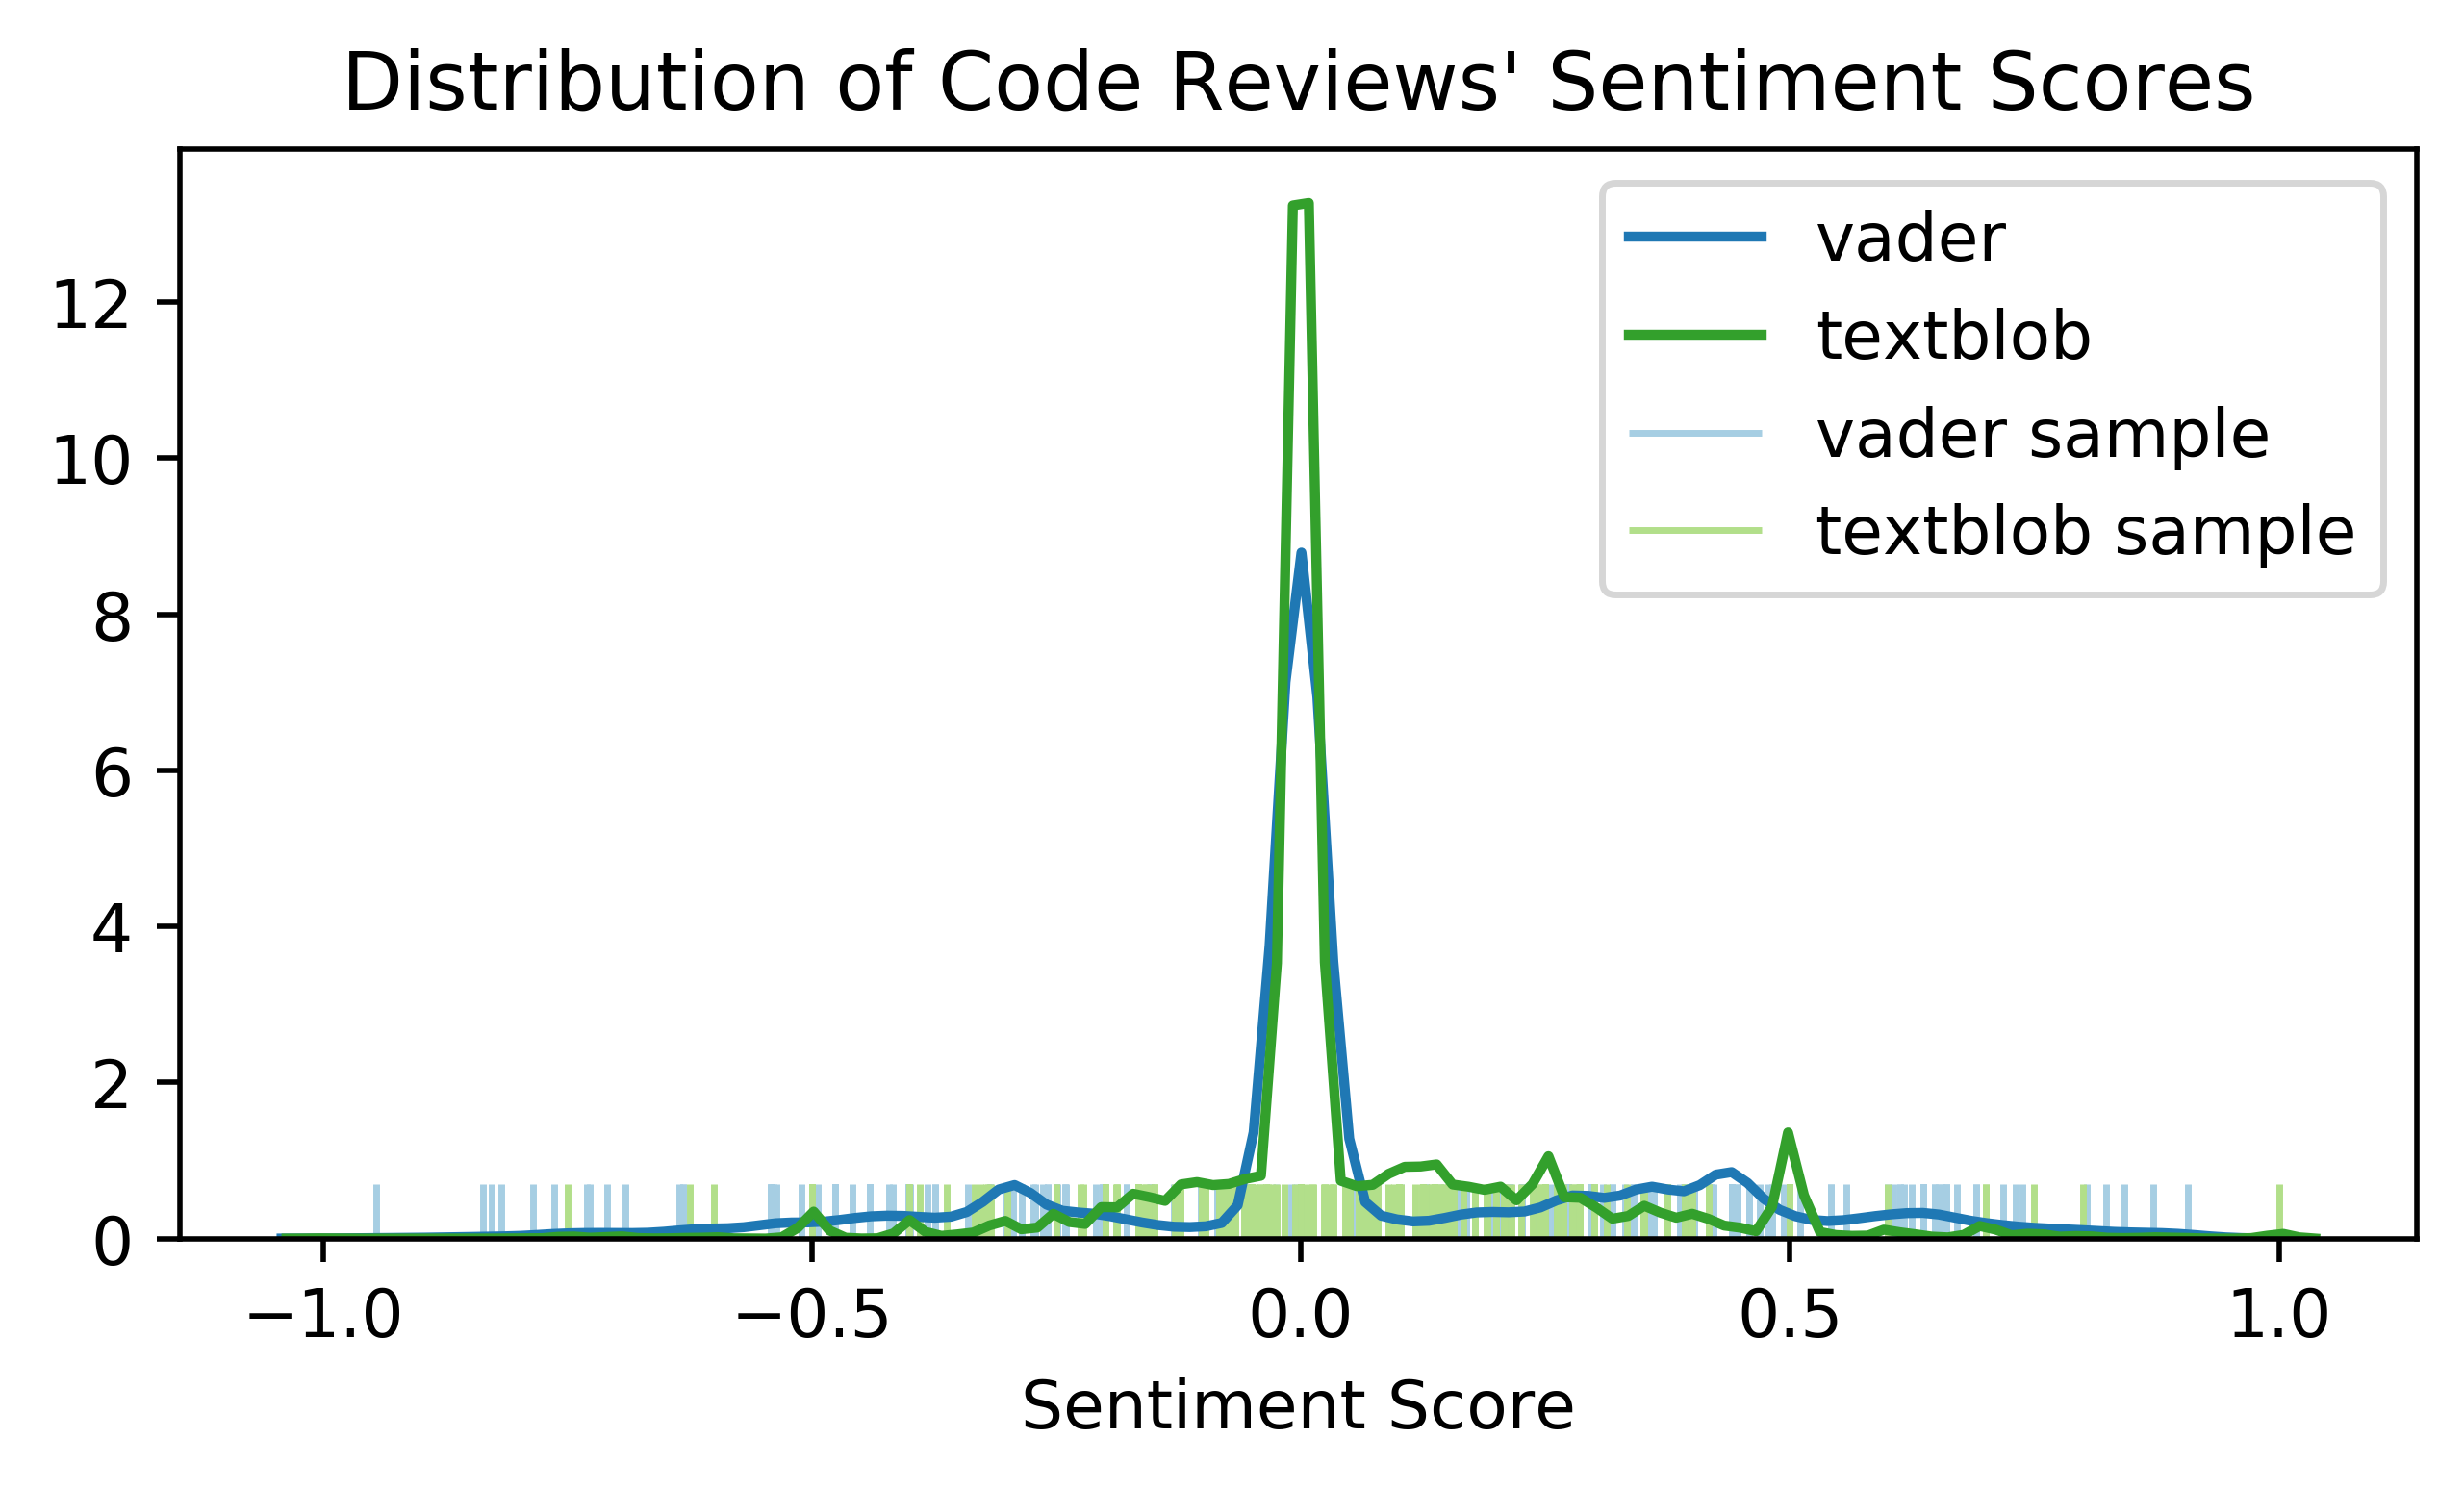

In [37]:
import seaborn as sns
plt.rcParams['figure.dpi'] = 250
plt.rcParams['figure.figsize'] = 6.0, 3.0

sns.set_palette("Paired")
sample_score = data_scores.sample(frac=0.05, replace=True, random_state=1)

sns.distplot(sample_score['vader'], label='vader sample',kde=False, hist=False, rug=True)
sns.distplot(data_scores['vader'], label='vader', hist=False, rug=False)
sns.distplot(sample_score['textblob'], label='textblob sample', kde=False, hist=False, rug=True)
sns.distplot(data_scores['textblob'], label='textblob', hist=False, rug=False)

plt.title("Distribution of Code Reviews' Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.legend()
plt.show()

In [38]:
small_sample_score = data_scores.sample(frac=0.01, replace=False, random_state=1)
print(len(small_sample_score))

102


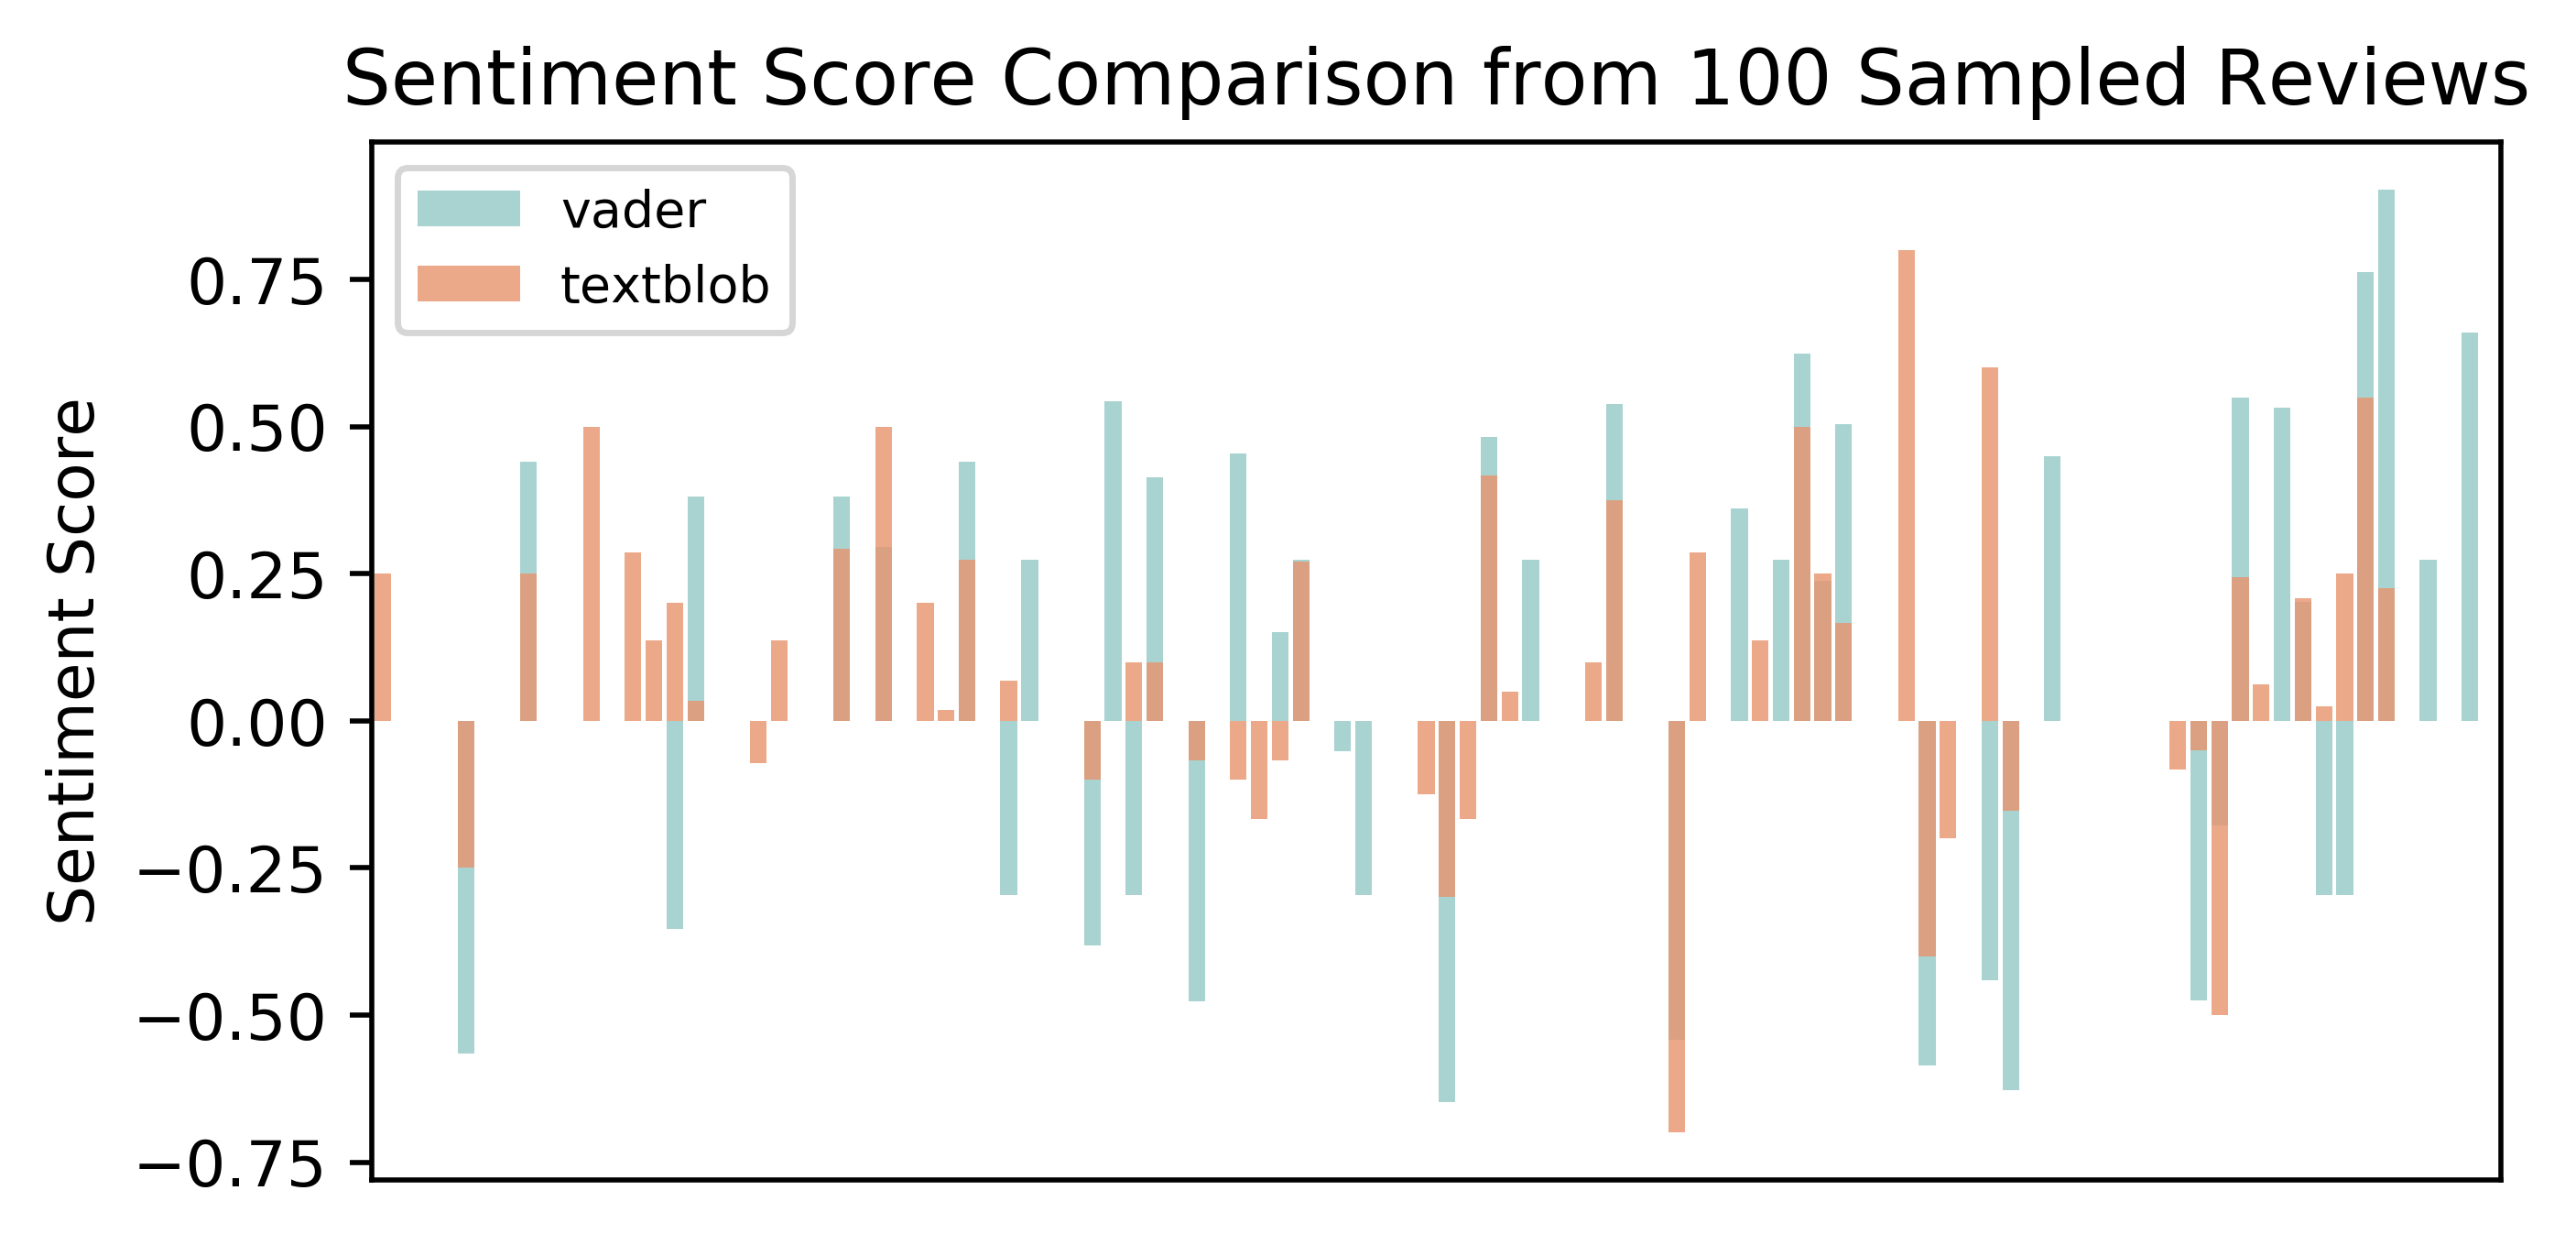

11
I've been doing sanitization back-end for all my slices.1. Future developers may be confused on why some things are c:out-ed and some things are not.2. You don't know what's actually happening in c:out. It's very clear what Sanitizer.sanitizeForHtml does.3. As mentioned [here](http://tech.finn.no/2011/04/08/xss-protection-whos-responsibility/)
vader:  0.1513
textblob -0.0675
14
Missing space; also capitalise the first letter.
vader:  -0.29600000000000004
textblob 0.024999999999999998
40
I don't think you should remove the header comment entirely. If it's no longer relevant, update it.
vader:  -0.3535
textblob 0.2
41
No, this must not be done. UserType is specific for each instance of ActivityLogEntry and thus must not be static.
vader:  -0.29600000000000004
textblob 0.25
53
Will continue tonight
vader:  -0.29600000000000004
textblob 0.06753246753246753
64
This block could be extracted into its own method.
vader:  -0.4404
textblob 0.6
70
Maybe for the status messages in this action, 

In [39]:
sns.barplot(x=list(small_sample_score.index), y=small_sample_score['vader'],orient='v',label='vader',palette=sns.color_palette("GnBu",1),alpha=0.7)
sns.barplot(x=list(small_sample_score.index), y=small_sample_score['textblob'],orient='v',label='textblob',palette=sns.color_palette("OrRd",1),alpha=0.8)

plt.title('Sentiment Score Comparison from 100 Sampled Reviews')
plt.ylabel('Sentiment Score')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.legend(prop={'size': 8})
plt.show()
neu = []
for i in range(len(small_sample_score)):
    if small_sample_score['vader'].values[i] > 0 and small_sample_score['textblob'].values[i] < 0:
        print(i)
        print(small_sample_score['body'].values[i])
        print('vader: ',small_sample_score['vader'].values[i])
        print('textblob', small_sample_score['textblob'].values[i])
    if small_sample_score['vader'].values[i] < 0 and small_sample_score['textblob'].values[i] > 0:
        print(i)
        print(small_sample_score['body'].values[i])
        print('vader: ',small_sample_score['vader'].values[i])
        print('textblob', small_sample_score['textblob'].values[i])
    if small_sample_score['vader'].values[i] == 0 and small_sample_score['textblob'].values[i] == 0:
        neu.append(i)
print(neu)

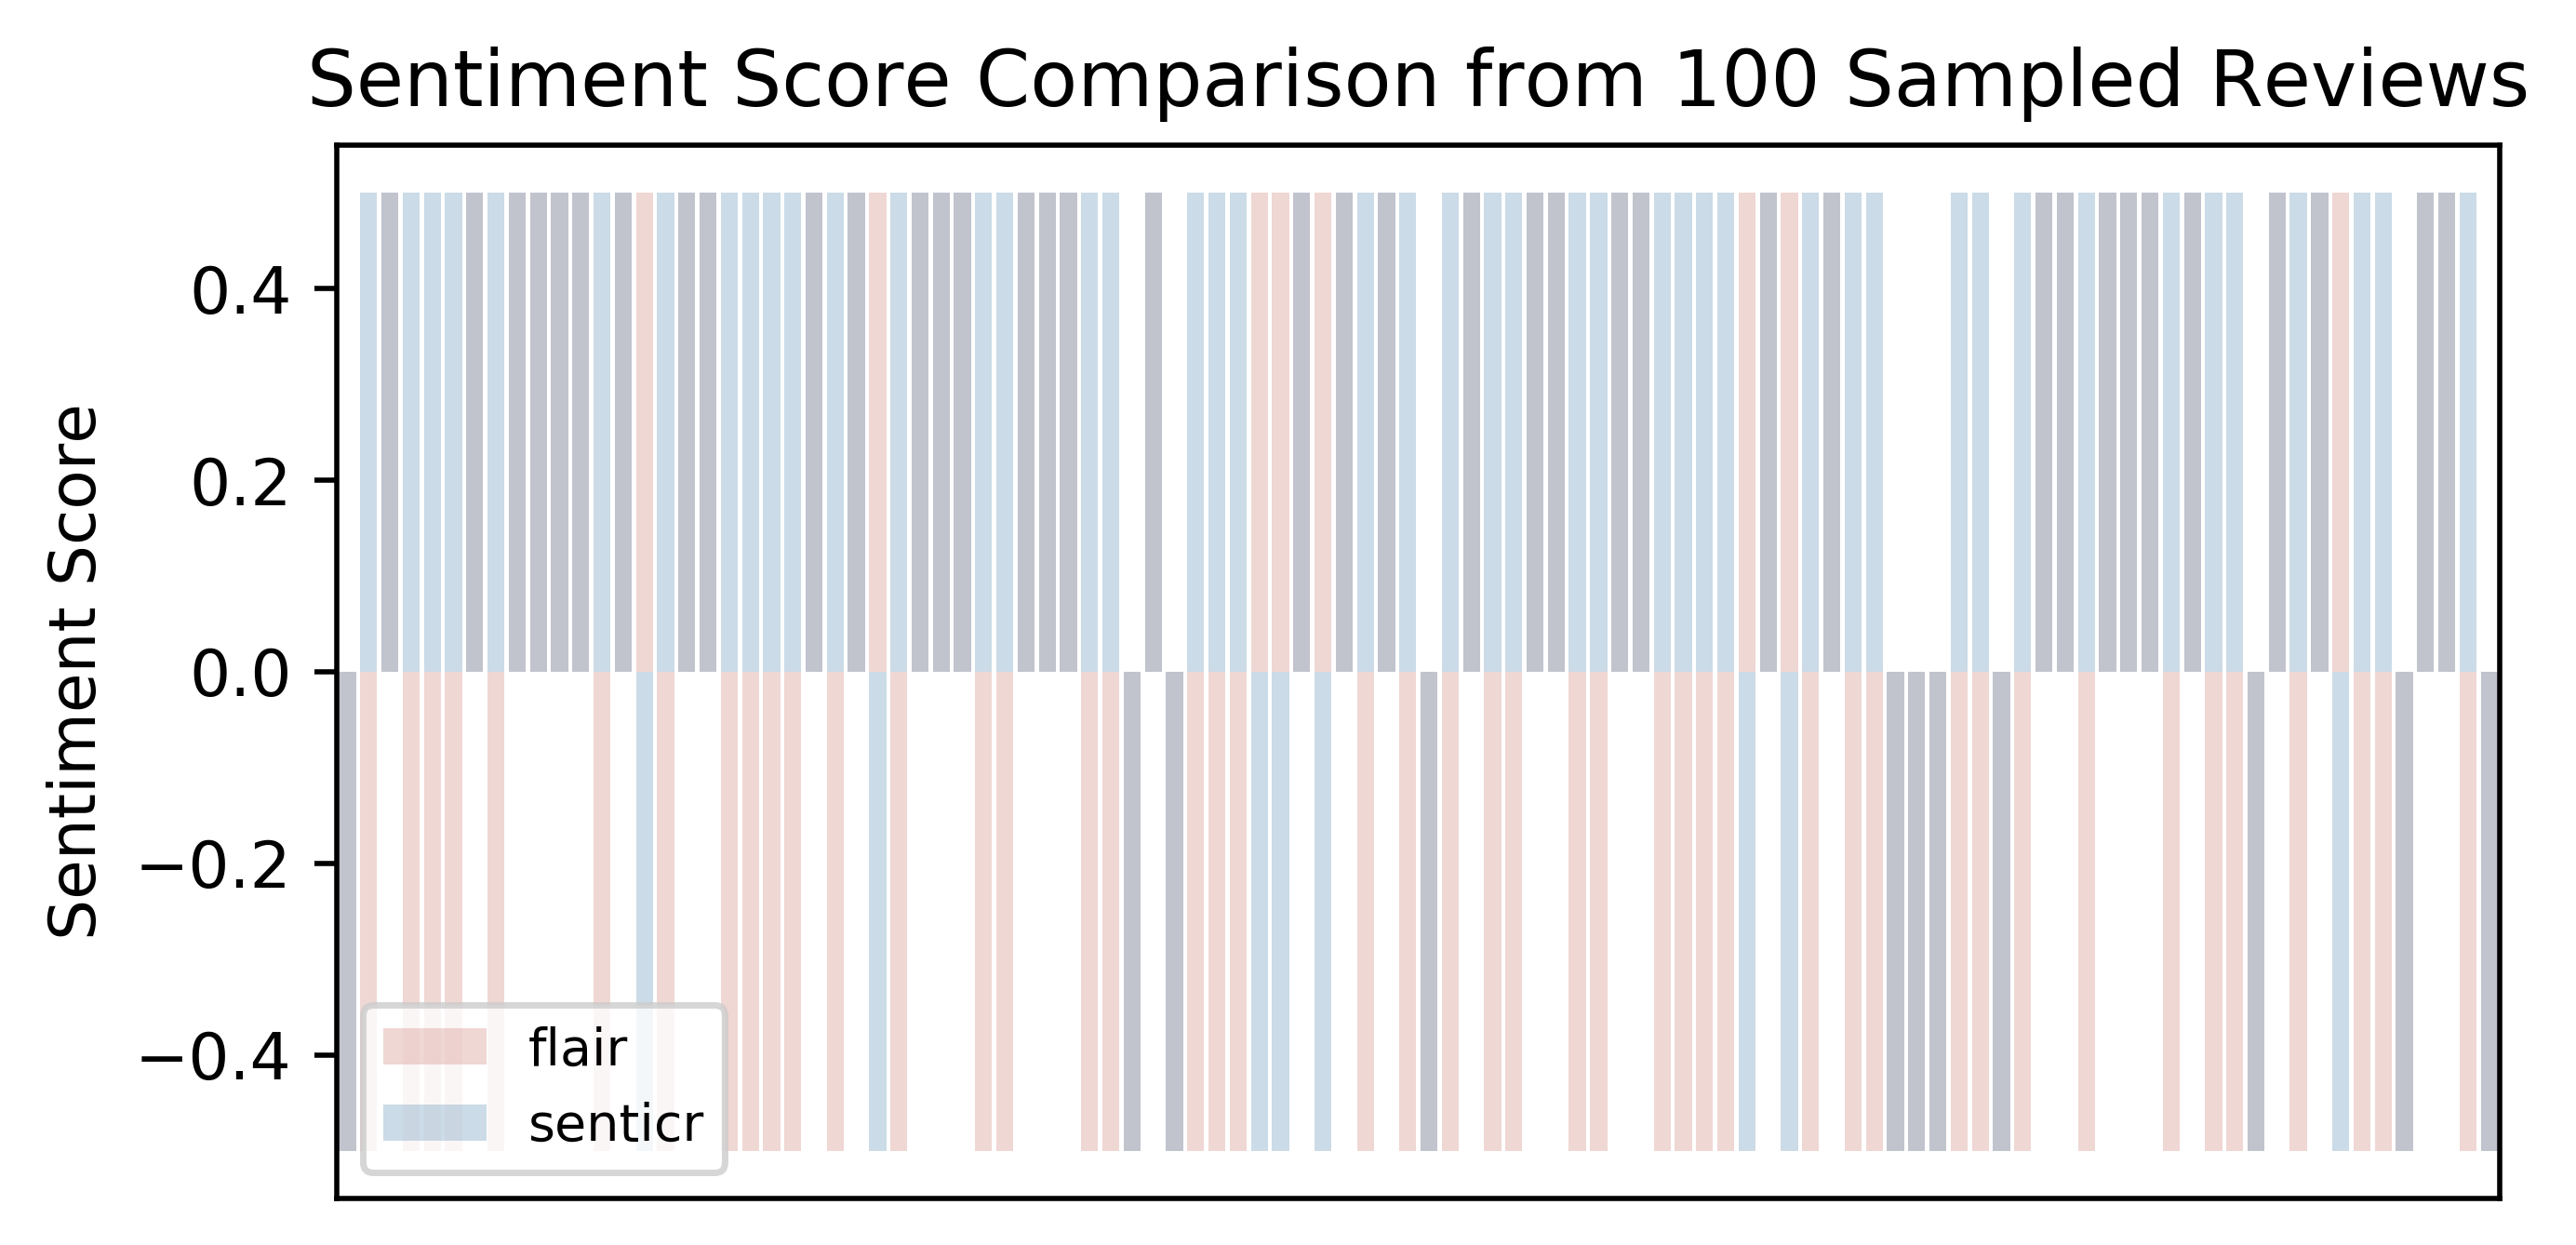

2
Add a header comment here as well, in particular not everyone will be familiar with what Content-Disposition is.
flair:  0.0
senticr -1.0
3
Are there better names for the 2 pages beside "First" and "Second"?
flair:  -1.0
senticr 0.0
5
Should documents be reused here and later so that successfully put documents are not being put again?
flair:  -1.0
senticr 0.0
6
Similarly here.
flair:  -1.0
senticr 0.0
7
//comment id is null when adding new comments
flair:  -1.0
senticr 0.0
8
This wastes too much space. Compacting everything to one line should work.
flair:  -1.0
senticr 0.0
9
This looks like it should be set in Const class instead.
flair:  -1.0
senticr 0.0
11
I've been doing sanitization back-end for all my slices.1. Future developers may be confused on why some things are c:out-ed and some things are not.2. You don't know what's actually happening in c:out. It's very clear what Sanitizer.sanitizeForHtml does.3. As mentioned [here](http://tech.finn.no/2011/04/08/xss-protection-whos-re

In [40]:
# 2, 3, 5, 6, 7, 8, 9, 11, 15, 16, 18, 23, 24, 25, 26, 29, 31, 33, 35, 40, 41, 42, 43, 44, 45, 46, 52, 53, 55, 56, 57, 59, 63, 64, 66, 67, 69, 70, 72, 73, 74, 77, 78, 79, 83, 90, 91, 94, 96, 98, 99, 100, 101
sns.barplot(x=list(small_sample_score.index), y=small_sample_score['flair']+0.5,orient='v',label='flair',color="salmon",saturation=0.5,alpha=0.4)
sns.barplot(x=list(small_sample_score.index), y=small_sample_score['senticr']+0.5,orient='v',label='senticr',palette=sns.color_palette("PuBu",1),alpha=0.4)
plt.title('Sentiment Score Comparison from 100 Sampled Reviews')
plt.ylabel('Sentiment Score')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.legend(prop={'size': 8})
plt.show()
diff = []
for i in range(len(small_sample_score)):
    if small_sample_score['flair'].values[i] == 0 and small_sample_score['senticr'].values[i] < 0:
        print(i)
        diff.append(i)
        print(small_sample_score['body'].values[i])
        print('flair: ',small_sample_score['flair'].values[i])
        print('senticr', small_sample_score['senticr'].values[i])
    if small_sample_score['flair'].values[i] < 0 and small_sample_score['senticr'].values[i] == 0:
        print(i)
        print(small_sample_score['body'].values[i])
        print('flair: ',small_sample_score['flair'].values[i])
        print('senticr', small_sample_score['senticr'].values[i])
        diff.append(i)
print(diff)
print(len(diff))

In [41]:
#stats
pos_flair = len(data_scores[data_scores['flair'] == 0])
pos_vader = len(data_scores[data_scores['vader'] > 0])
pos_textblob = len(data_scores[data_scores['textblob'] > 0])
pos_senticr = len(data_scores[data_scores['senticr'] == 0])

neg_flair = len(data_scores[data_scores['flair'] < 0])
neg_vader = len(data_scores[data_scores['vader'] < 0])
neg_textblob = len(data_scores[data_scores['textblob'] < 0])
neg_senticr = len(data_scores[data_scores['senticr'] < 0])

neu_vader = len(data_scores[data_scores['vader'] == 0])
neu_textblob = len(data_scores[data_scores['textblob'] == 0])

diff_vader_textblob = len(data_scores[(data_scores['vader']>0) & (data_scores['textblob']<0)])+len(data_scores[(data_scores['vader']<0) & (data_scores['textblob']>0)])
diff_senticr_flair = len(data_scores[(data_scores['flair']<0) & (data_scores['senticr']==0)])+len(data_scores[(data_scores['flair']<0) & (data_scores['senticr']==0)])
diff_flair_vader = len(data_scores[(data_scores['vader']>0) & (data_scores['flair']<0)])+len(data_scores[(data_scores['vader']<0) & (data_scores['flair']==0)])
print("pos_flair: ", pos_flair," neg_flair: ", neg_flair)
print("pos_vader: ", pos_vader," neg_vader: ", neg_vader)
print("pos_textblob: ", pos_textblob," neg_textblob: ", neg_textblob)
print("pos_senticr: ", pos_senticr," neg_senticr: ", neg_senticr)

# print("neg_flair: ", neg_flair)
# print("neg_vader: ", neg_vader)
# print("neg_textblob: ", neg_textblob)
# print("neg_senticr: ", neg_senticr)

print("neu_textblob: ", neu_textblob)
print("neu_vader: ", neu_vader)

print("diff_vader_textblob: ", diff_vader_textblob)
print("diff_senticr_flair: ", diff_senticr_flair)
print("diff_flair_vader: ", diff_flair_vader)
print("total : ", len(data_scores))



pos_flair:  4433  neg_flair:  5768
pos_vader:  2998  neg_vader:  1812
pos_textblob:  3169  neg_textblob:  1707
pos_senticr:  8675  neg_senticr:  1526
neu_textblob:  5325
neu_vader:  5391
diff_vader_textblob:  827
diff_senticr_flair:  9482
diff_flair_vader:  2477
total :  10201


In [ ]:
data_scores.to_csv('code_to_score/saved_data/data_scores.csv')

### Continue Data Preprocessing

In [42]:
score_method = 'flair'
#score_method = 'senticr'
#score_method = 'vader'
#score_method = 'textblob'
is_classification = score_method == 'flair' or score_method == 'senticr'

In [43]:
def data_preprocess(data, idx, method):
    i = idx
    for record in data:
        clean_body = record['body'].replace("`", "").replace("\n", "")
        if is_classification:
            record['score'] = int(data_scores[method].values[i] + 1) # classification 
        else:
            record['score'] = data_scores[method].values[i] # regression
        record['diff_hunk_encoded'] = pad_sequence(numerize_diff_hunk(record['augmented_diff_hunk']))
        record['diff_hunk_mask'] = calculate_mask(record['diff_hunk_encoded'])
        i += 1
    print(i)
data_preprocess(train_data, 0, score_method)
data_preprocess(val_data, len(train_data), score_method)
data_preprocess(test_data, len(train_data) + len(val_data), score_method)

7629
8976
10201


In [44]:
def numerized_to_diff(numerized):
    return "".join([i2c.get(i) for i in numerized])

In [45]:
train_data[0]['augmented_diff_hunk']

'--- TimeHelper.java\n+++ TimeHelper.java\n@@ -28,7 +28,8 @@\n     static{\n         map("-12.0", "Baker Island, Howland Island");\n         map("-11.0", "American Samoa, Niue");\n-        map("-10.0", "Hawaii, Cook Islands, Marquesas Islands");\n+        map("-10.0", "Hawaii, Cook Islands");\n+        map("-9.5", "Marquesas Islands");'

In [46]:
numerized_to_diff(train_data[0]['diff_hunk_encoded'])

'--- TimeHelper.java\n+++ TimeHelper.java\n@@ -28,7 +28,8 @@\n     static{\n         map("-12.0", "Baker Island, Howland Island");\n         map("-11.0", "American Samoa, Niue");\n-        map("-10.0", "Hawaii, Cook Islands, Marquesas Islands");\n+        map("-10.0", "Hawaii, Cook Islands");\n+        map("'

In [47]:
for i in np.random.choice(len(train_data), 3):
    print(train_data[i]['body'])
    print(train_data[i]['score'])

would `shouldShow` be better?
1
- This error message should be able to be generated with `getPopulatedErrorMessage`, as what is done for others.
- `expectedError` is vague; expected what kind of error?
0
FEEDBACK_RESPONSE_COMMENT_ADD_TEXT -> FEEDBACK_RESPONSE_COMMENT_ADD_FORM
1


## Build Batch

In [48]:
def build_batch(dataset, batch_size):
    indices = list(np.random.randint(0, len(dataset), size=min(batch_size, len(dataset))))
    
    batch = [dataset[i] for i in indices]
    
    X_encoded = np.array([element['diff_hunk_encoded'] for element in batch])
    X_mask = np.array([element['diff_hunk_mask'] for element in batch])
    
    y_target = np.array([element['score'] for element in batch])

    return X_encoded, X_mask, y_target

In [49]:
X_encoded, X_mask, y_target = build_batch(train_data, 10)

In [50]:
print(X_encoded.shape)
print(X_mask.shape)
print(y_target.shape)

(10, 300)
(10, 300)
(10,)


## Model

In [51]:
import torch
import torch.nn as nn

In [52]:
from code_to_score.models.code_to_score_transformer import CodeToScoreModelTransformer

## Visualization

In [53]:
from util.training_process_recorder import TrainingProcess

## Trainning

In [54]:
from sklearn.metrics import accuracy_score

In [55]:
code_to_score_model = CodeToScoreModelTransformer(
    should_tune_encoder=True,
    is_classification=is_classification, class_weight=[1, 1.3],
    code_max_length=diff_max_length, code_characters_size=len(i2c),
    hidden_size=400, num_hidden_layers=4, num_attention_heads=4, 
    intermediate_size=500)
code_to_score_model = code_to_score_model.to(code_to_score_model.device)

In [56]:
tp = TrainingProcess()
tp_acc = TrainingProcess()
baseline_acc_list = []

In [57]:
if torch.cuda.is_available():
    code_to_score_model.load_state_dict(torch.load('code_to_score/saved_data/{}_code_to_score_transformer.save'.format(score_method)))
else:
    code_to_score_model.load_state_dict(torch.load('code_to_score/saved_data/{}_code_to_score_transformer.save'.format(score_method), 
                                                    map_location=torch.device('cpu')))

code_to_score_model.eval();
tp.load("code_to_score/saved_data/{}_code_to_score_transformer_tp.save".format(score_method))
if is_classification:
    tp_acc.load("code_to_score/saved_data/{}_code_to_score_transformer_tp_acc.save".format(score_method))

In [ ]:
params = list(code_to_score_model.parameters())
optimizer = torch.optim.Adam(params, lr=0.0002, weight_decay=0.2) #0.00012
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.995)

num_epochs = 15
batch_size = 64
log_step = 30

for epoch in range(num_epochs):
    num_train = len(train_data)
    iterations_per_epoch = max(num_train // batch_size, 1)
    
    for i in range(iterations_per_epoch):
        minibatch = build_batch(train_data, batch_size)
        X_encoded, X_mask, y_target = minibatch
        code_to_score_model.train()
        code_to_score_model.zero_grad()
        loss = code_to_score_model(X_encoded, X_mask, y_target)
        loss.backward()
        optimizer.step()
        
        tp.record_train(loss.item())
        tp.step()
        
        # Print log info
        if i % log_step == 0:
            if is_classification:
                score_out = code_to_score_model(X_encoded, X_mask).argmax(dim=1)
                train_acc = accuracy_score(score_out.detach().cpu(), y_target)
                tp_acc.record_train(train_acc)
                print('Epoch [{}/{}], Step [{}/{}], Acc: {:.4f}'.format(epoch + 1, num_epochs, i, iterations_per_epoch, train_acc))
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i, iterations_per_epoch, loss.item()))
        
        if is_classification:
            tp_acc.step()

    val_minibatch = build_batch(val_data, batch_size)
    val_X_encoded, val_X_mask, val_y_target = val_minibatch
    code_to_score_model.eval()
    code_to_score_model.zero_grad()
    val_loss = code_to_score_model(val_X_encoded, val_X_mask, val_y_target)

    tp.record_val(val_loss.item())
    
    if is_classification:
        score_out = code_to_score_model(val_X_encoded, val_X_mask).argmax(dim=1)
        val_acc = accuracy_score(score_out.detach().cpu(), val_y_target)
        tp_acc.record_val(val_acc)
        print('Epoch [{}/{}], Validation Accuracy: {:.4f} '.format(epoch + 1, num_epochs, val_acc))

    print('Epoch [{}/{}], Validation Loss: {:.4f}'.format(epoch + 1, num_epochs, val_loss.item()))
    
    tp.record_epoch()
    if is_classification:
        tp_acc.record_epoch()
    
    my_lr_scheduler.step()

In [ ]:

for i in range(len(test_data) // 64):
    test_minibatch = build_batch(test_data, 64)
    test_X_encoded, test_X_mask, test_y_target = test_minibatch
    code_to_score_model.eval()
    code_to_score_model.zero_grad()
    test_loss = code_to_score_model(test_X_encoded, test_X_mask, test_y_target)
    
    tp.record_test(test_loss.item())
    
    if is_classification:
        score_out = code_to_score_model(test_X_encoded, test_X_mask).argmax(dim=1)
        test_acc = accuracy_score(score_out.detach().cpu(), test_y_target)
        tp_acc.record_test(test_acc)
        print('[Round {}] Test Accuracy: {:.4f}'.format(i + 1, test_acc))
        baseline_score = np.zeros(len(test_y_target))
        baseline_acc = accuracy_score(baseline_score, test_y_target)
        baseline_acc_list.append(baseline_acc)
        print('[Round {}] Baseline Test Accuracy: {:.4f}'.format(i + 1, baseline_acc))

    print('[Round {}] Test Loss: {:.4f}'.format(i + 1, test_loss.item()))

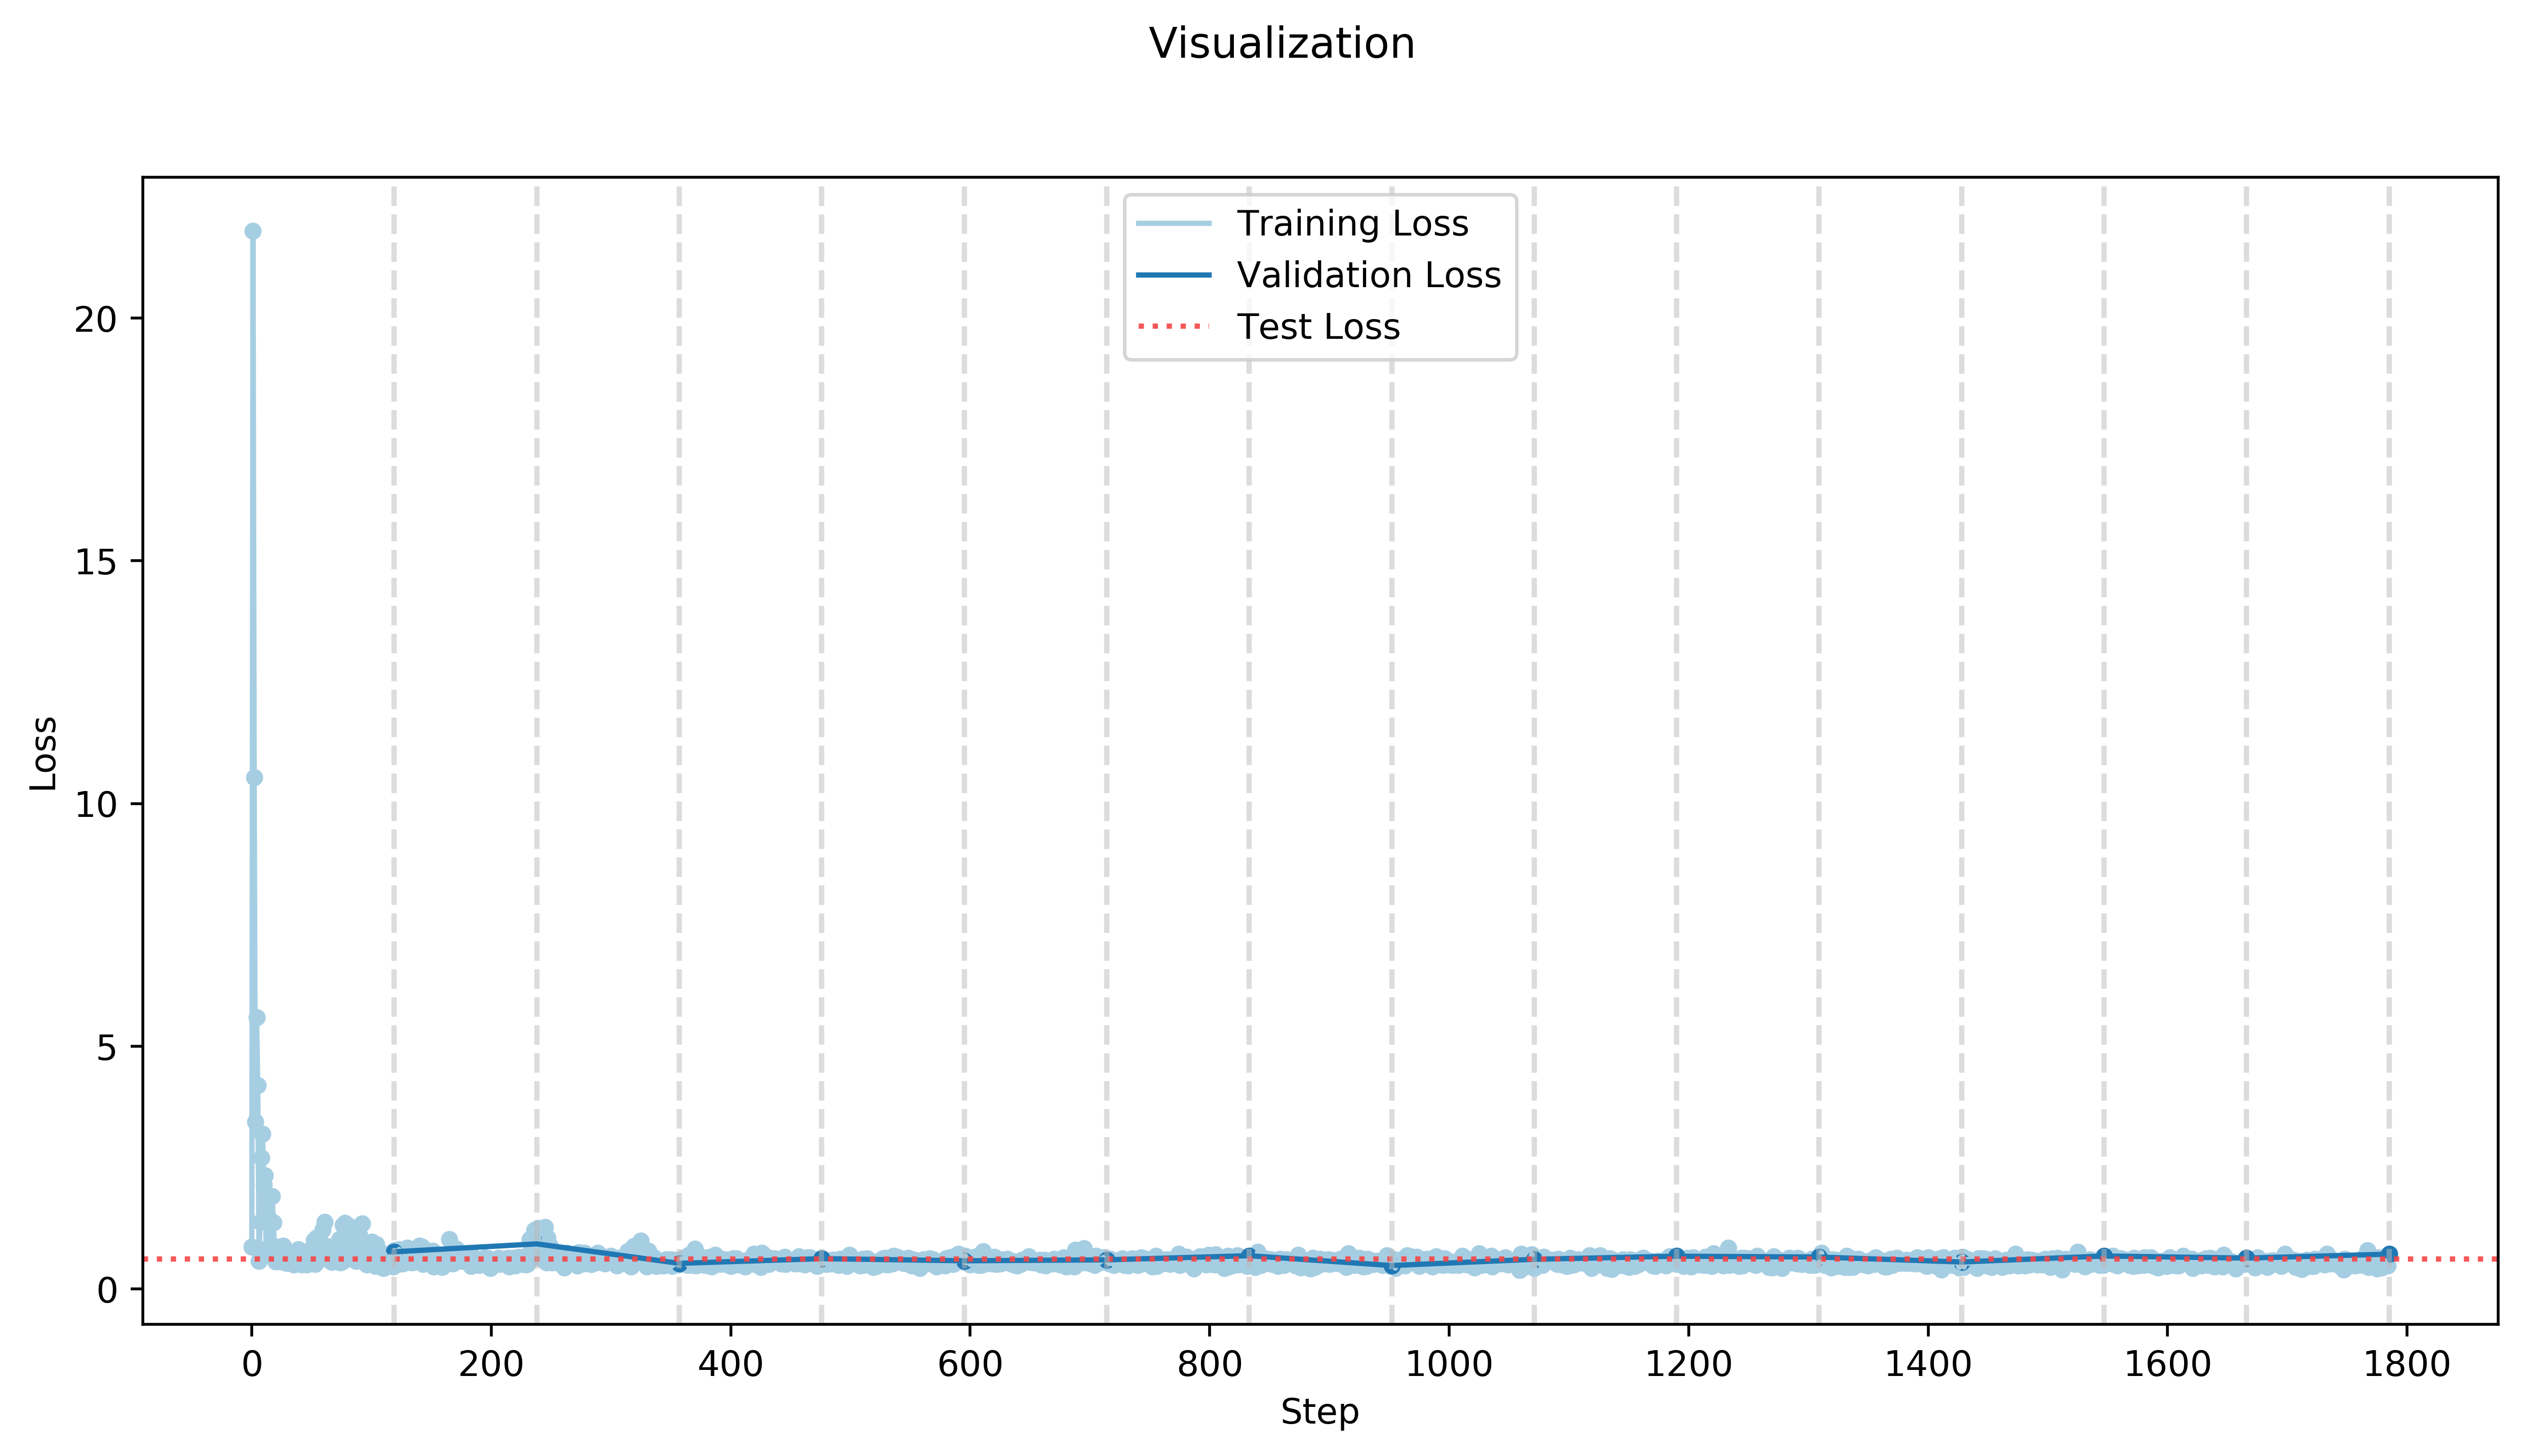

In [58]:
tp.visualize()

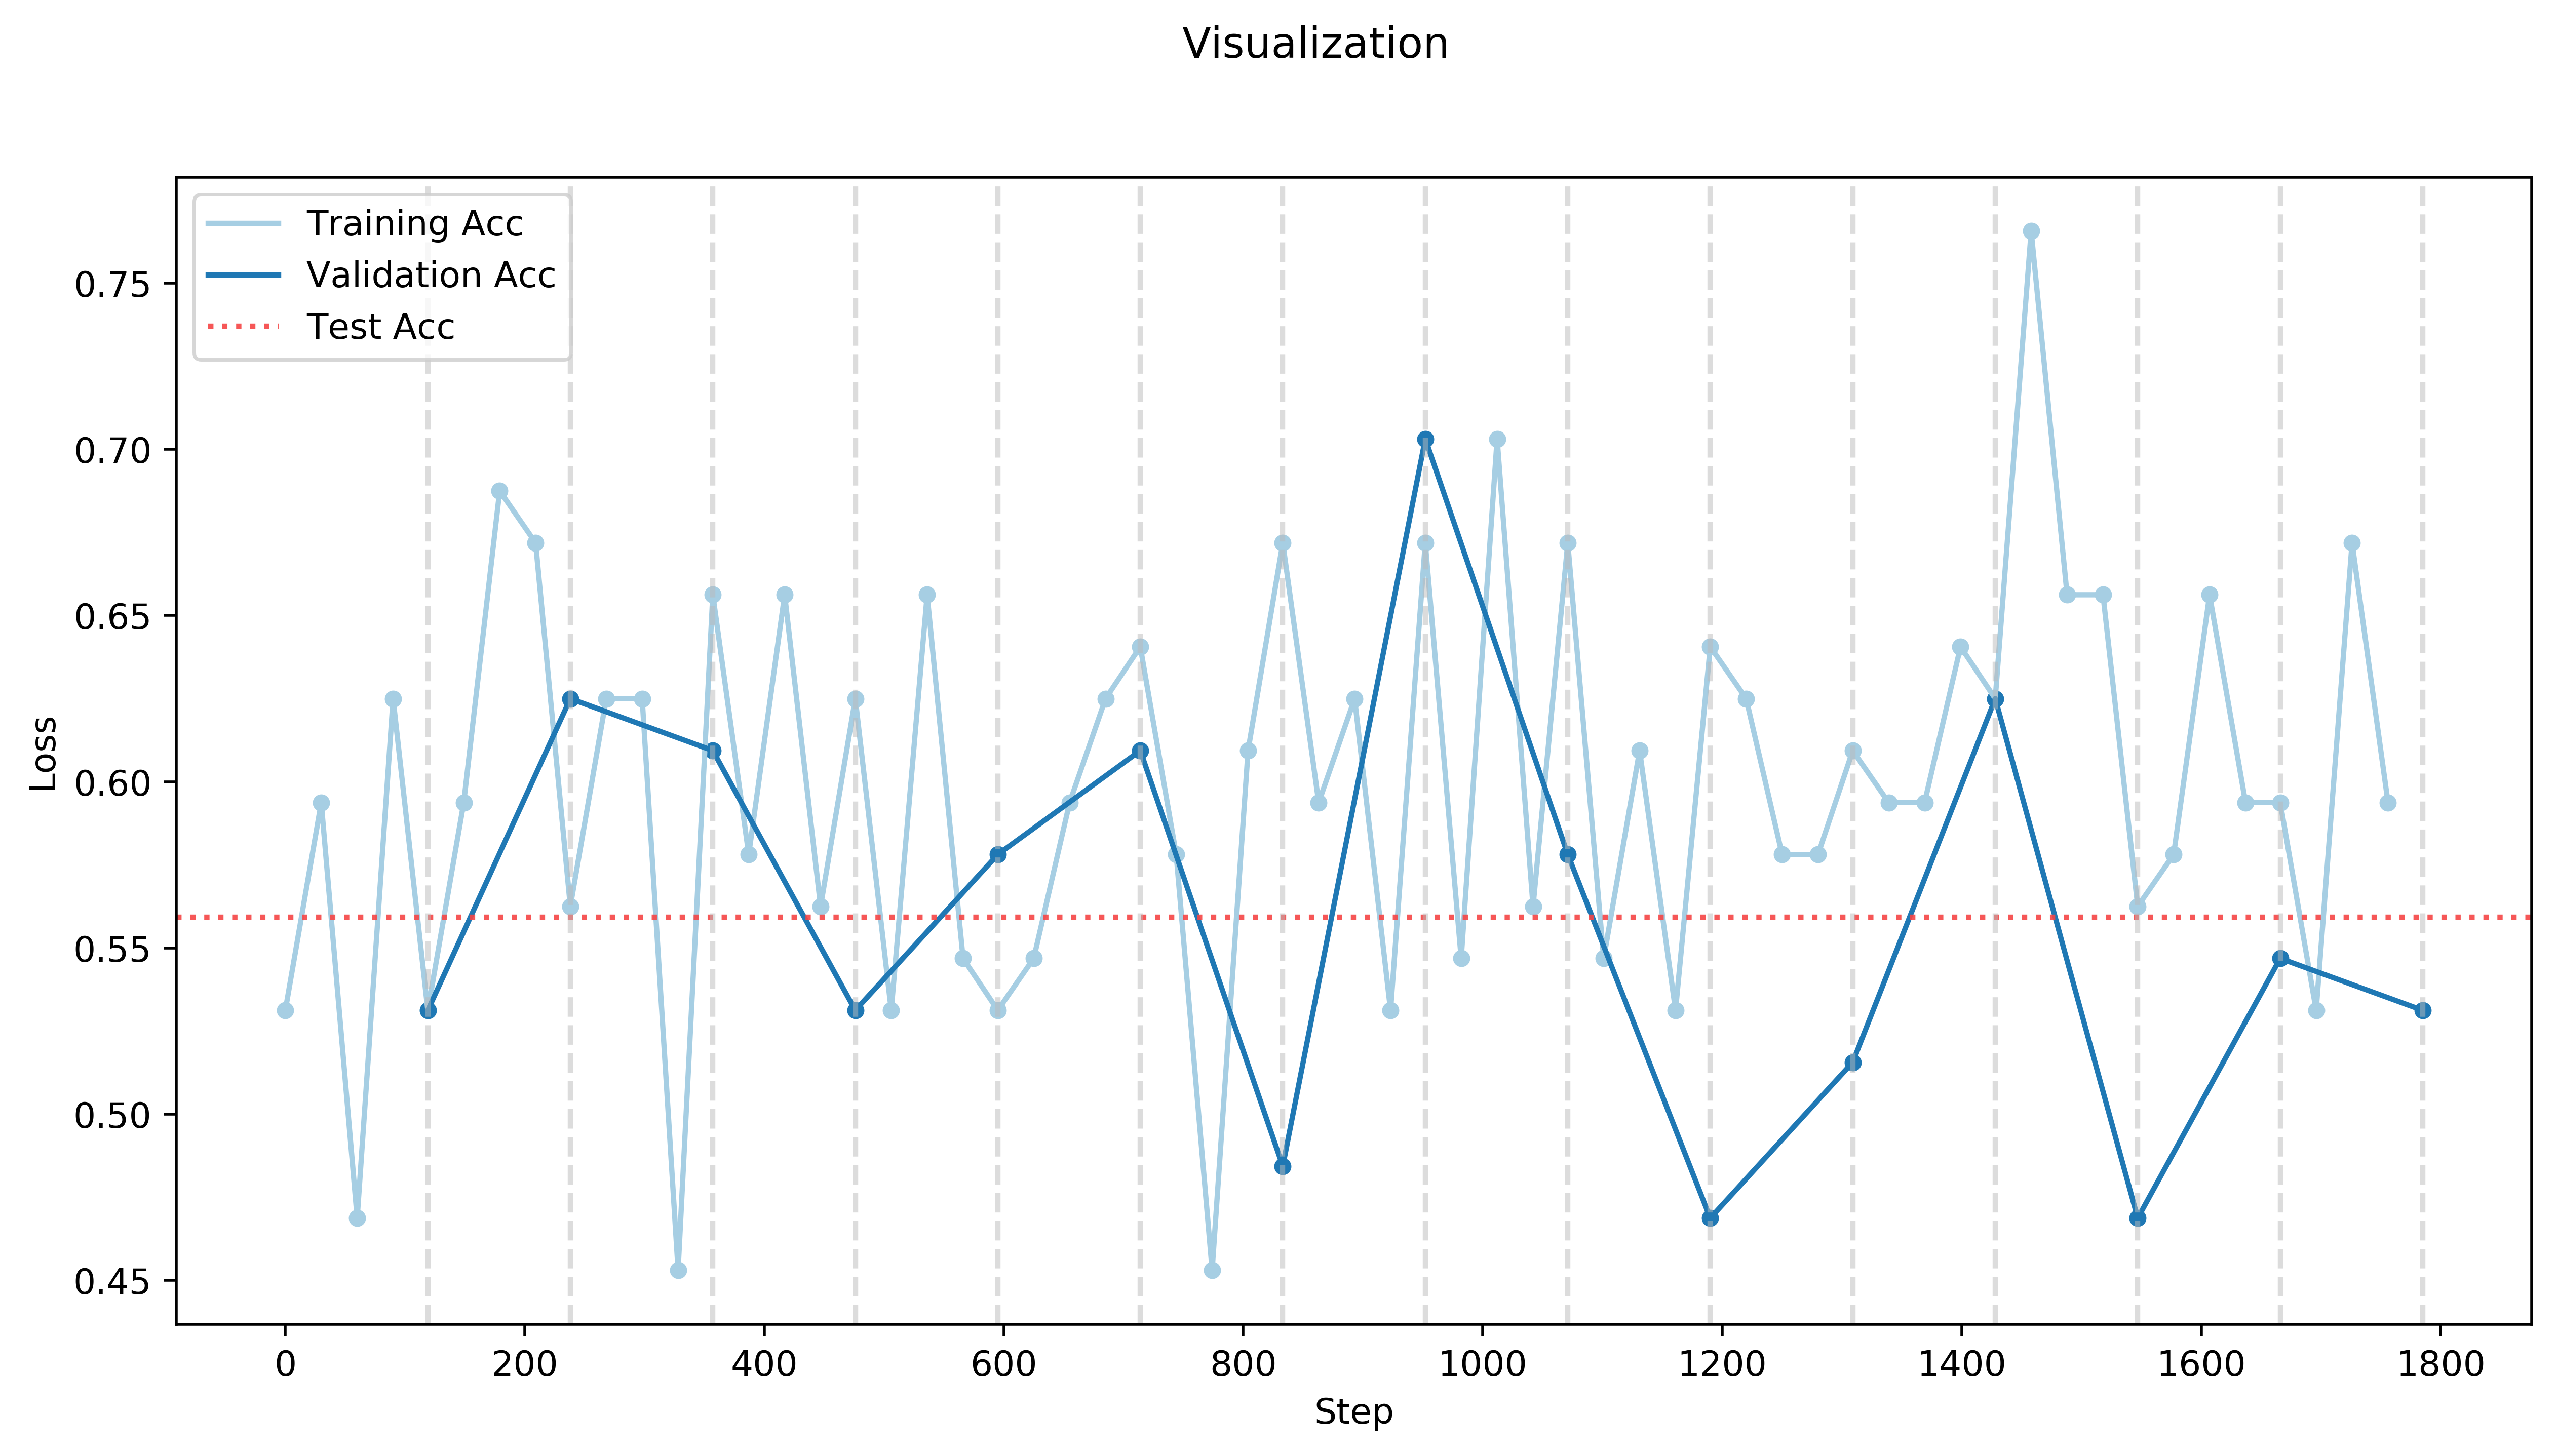

nan


/home/pu_xiao_berkeley_edu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/pu_xiao_berkeley_edu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [59]:
if is_classification:
    tp_acc.visualize(legend=['Training Acc', 'Validation Acc', 'Test Acc'])
    print(np.mean(baseline_acc_list))

In [ ]:
torch.save(code_to_score_model.state_dict(), 'code_to_score/saved_data/{}_code_to_score_transformer.save'.format(score_method))
tp.save('code_to_score/saved_data/{}_code_to_score_transformer_tp.save'.format(score_method))
if is_classification:
    tp_acc.save('code_to_score/saved_data/{}_code_to_score_transformer_tp_acc.save'.format(score_method))

## Testing

Text(0.5, 0, 'Score')

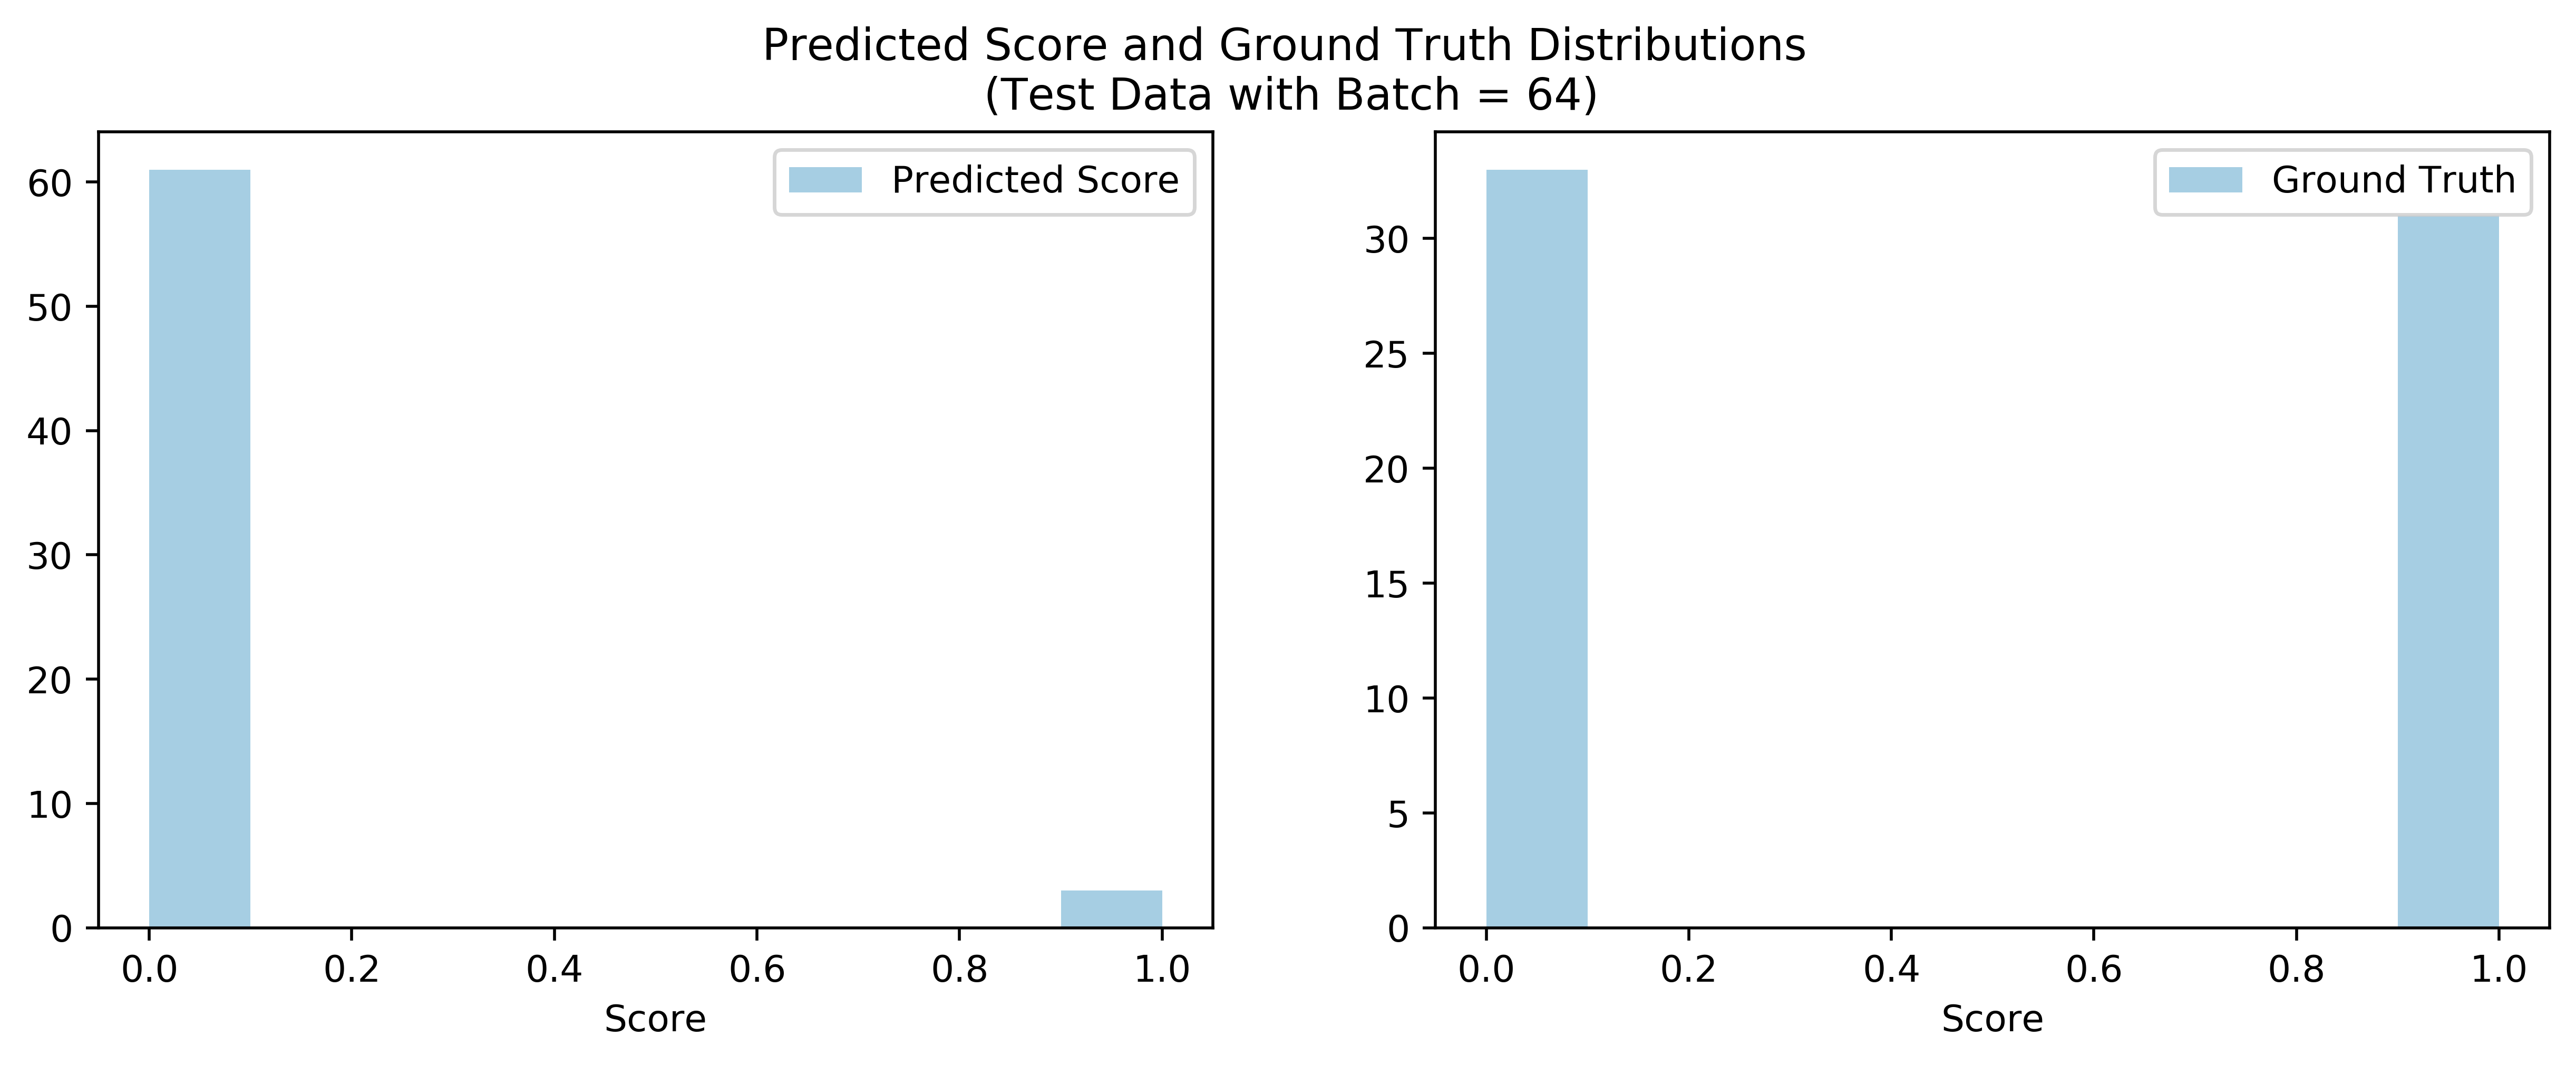

In [60]:
test_minibatch = build_batch(test_data, 64)
test_X_encoded, test_X_mask, test_y_target = test_minibatch

scores = code_to_score_model(test_X_encoded, test_X_mask).detach().cpu().numpy()

plt.figure(figsize=(12,4))
plt.subplot(121)

if is_classification:
    scores = np.argmax(scores, axis=1)

plt.hist(scores)
plt.legend(['Predicted Score',])
plt.xlabel('Score')

plt.subplot(122)
plt.hist(test_y_target)
plt.legend(['Ground Truth',])

plt.suptitle('Predicted Score and Ground Truth Distributions\n (Test Data with Batch = 64)')
plt.xlabel('Score')

Text(0.5, 0, 'Score')

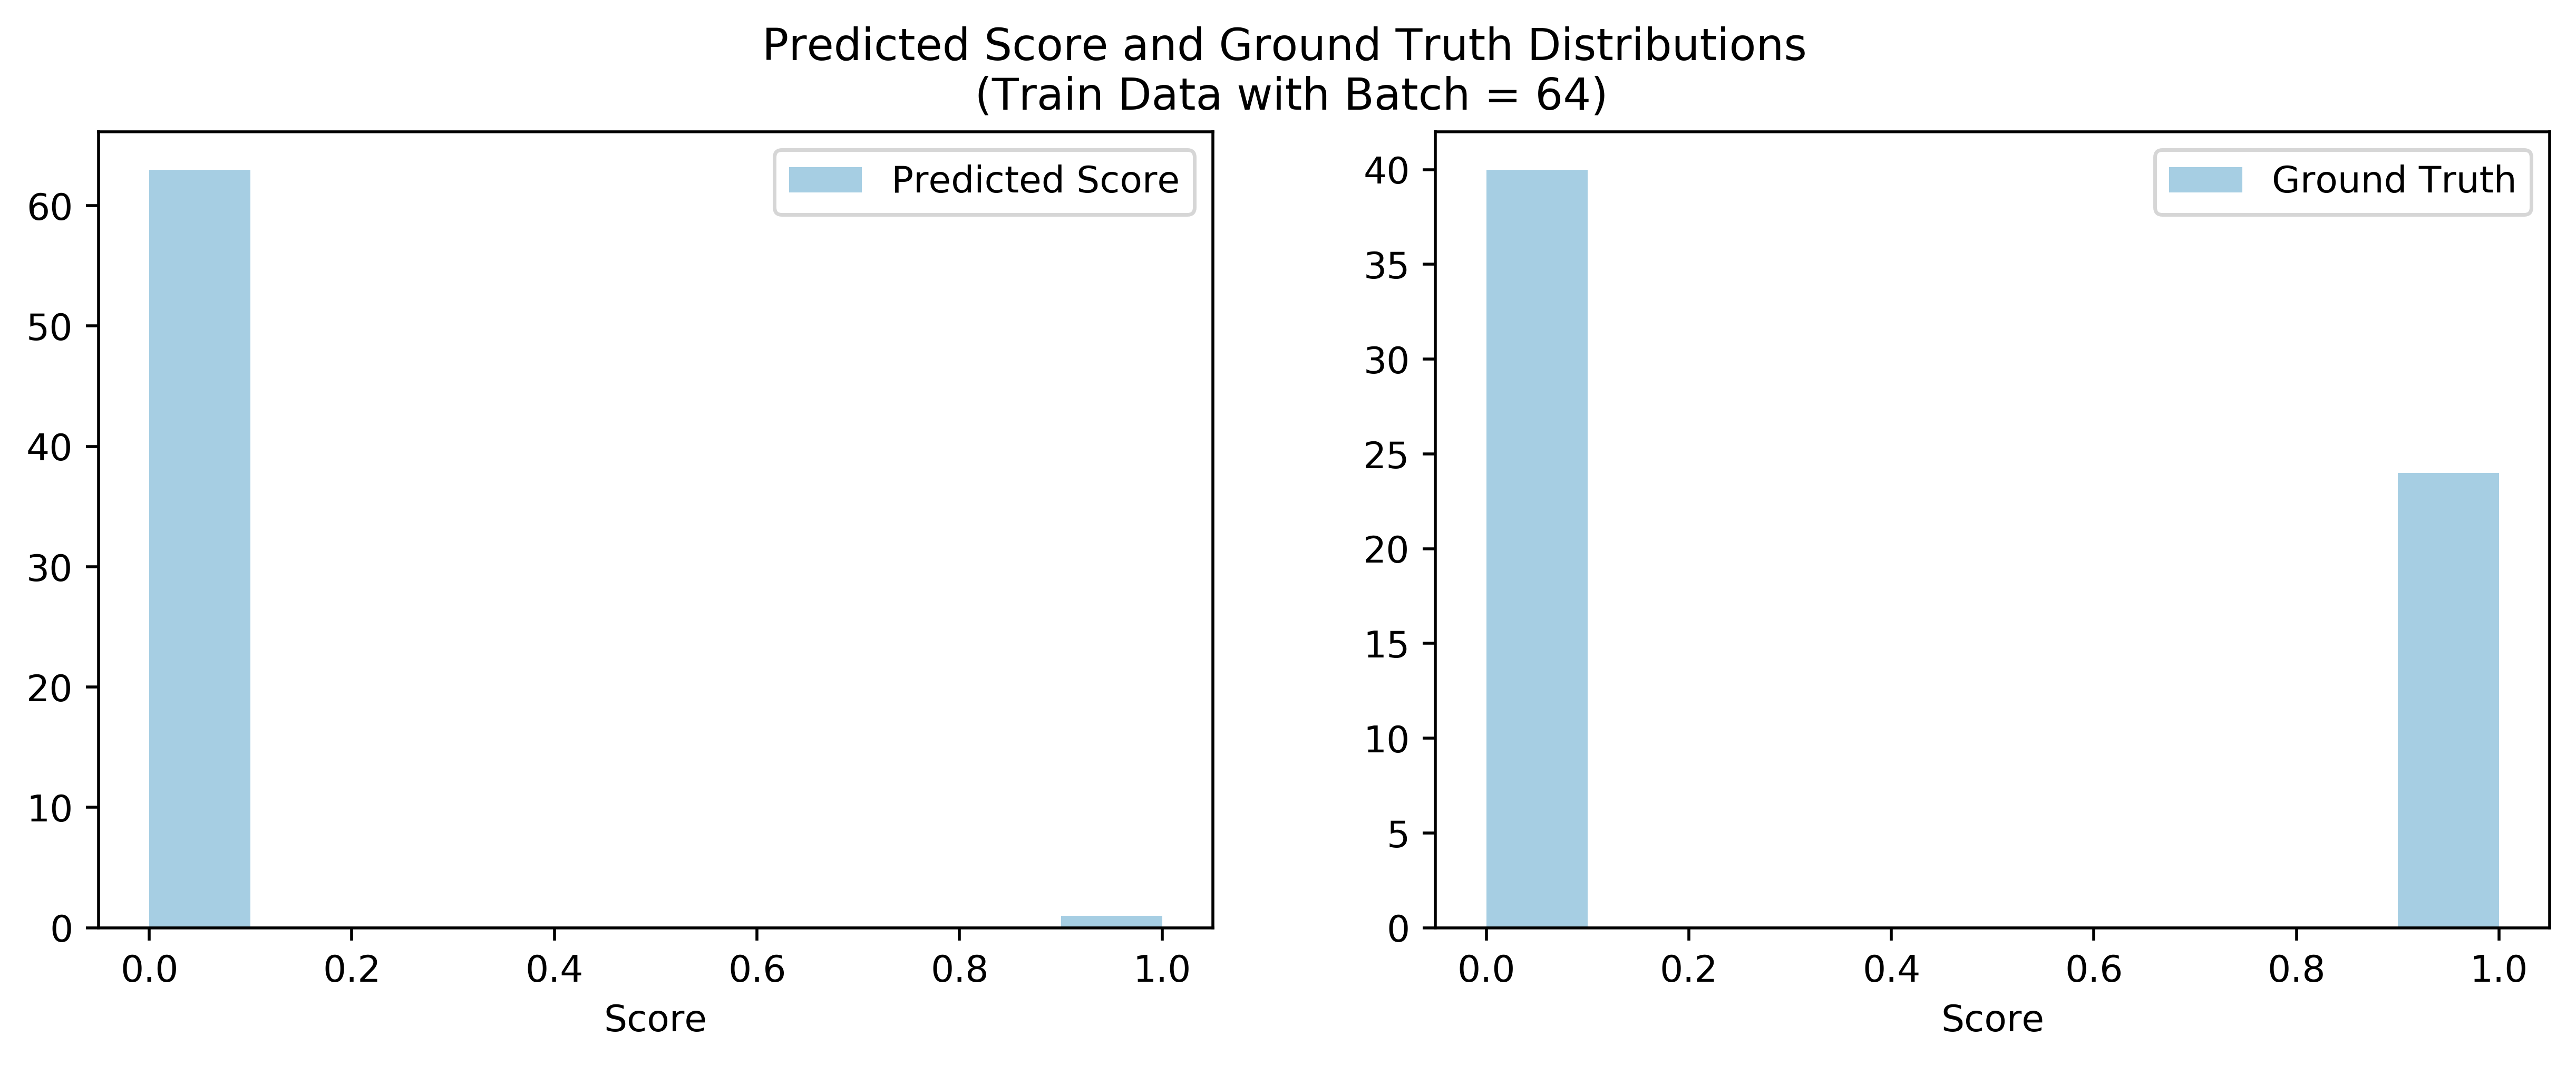

In [61]:
train_minibatch = build_batch(train_data, 64)
train_X_encoded, train_X_mask, train_y_target = train_minibatch

scores = code_to_score_model(train_X_encoded, train_X_mask).detach().cpu().numpy()

plt.figure(figsize=(12,4))
plt.subplot(121)

if is_classification:
    scores = np.argmax(scores, axis=1)

plt.hist(scores)
plt.legend(['Predicted Score',])
plt.xlabel('Score')

plt.subplot(122)
plt.hist(train_y_target)
plt.legend(['Ground Truth',])

plt.suptitle('Predicted Score and Ground Truth Distributions\n (Train Data with Batch = 64)')
plt.xlabel('Score')

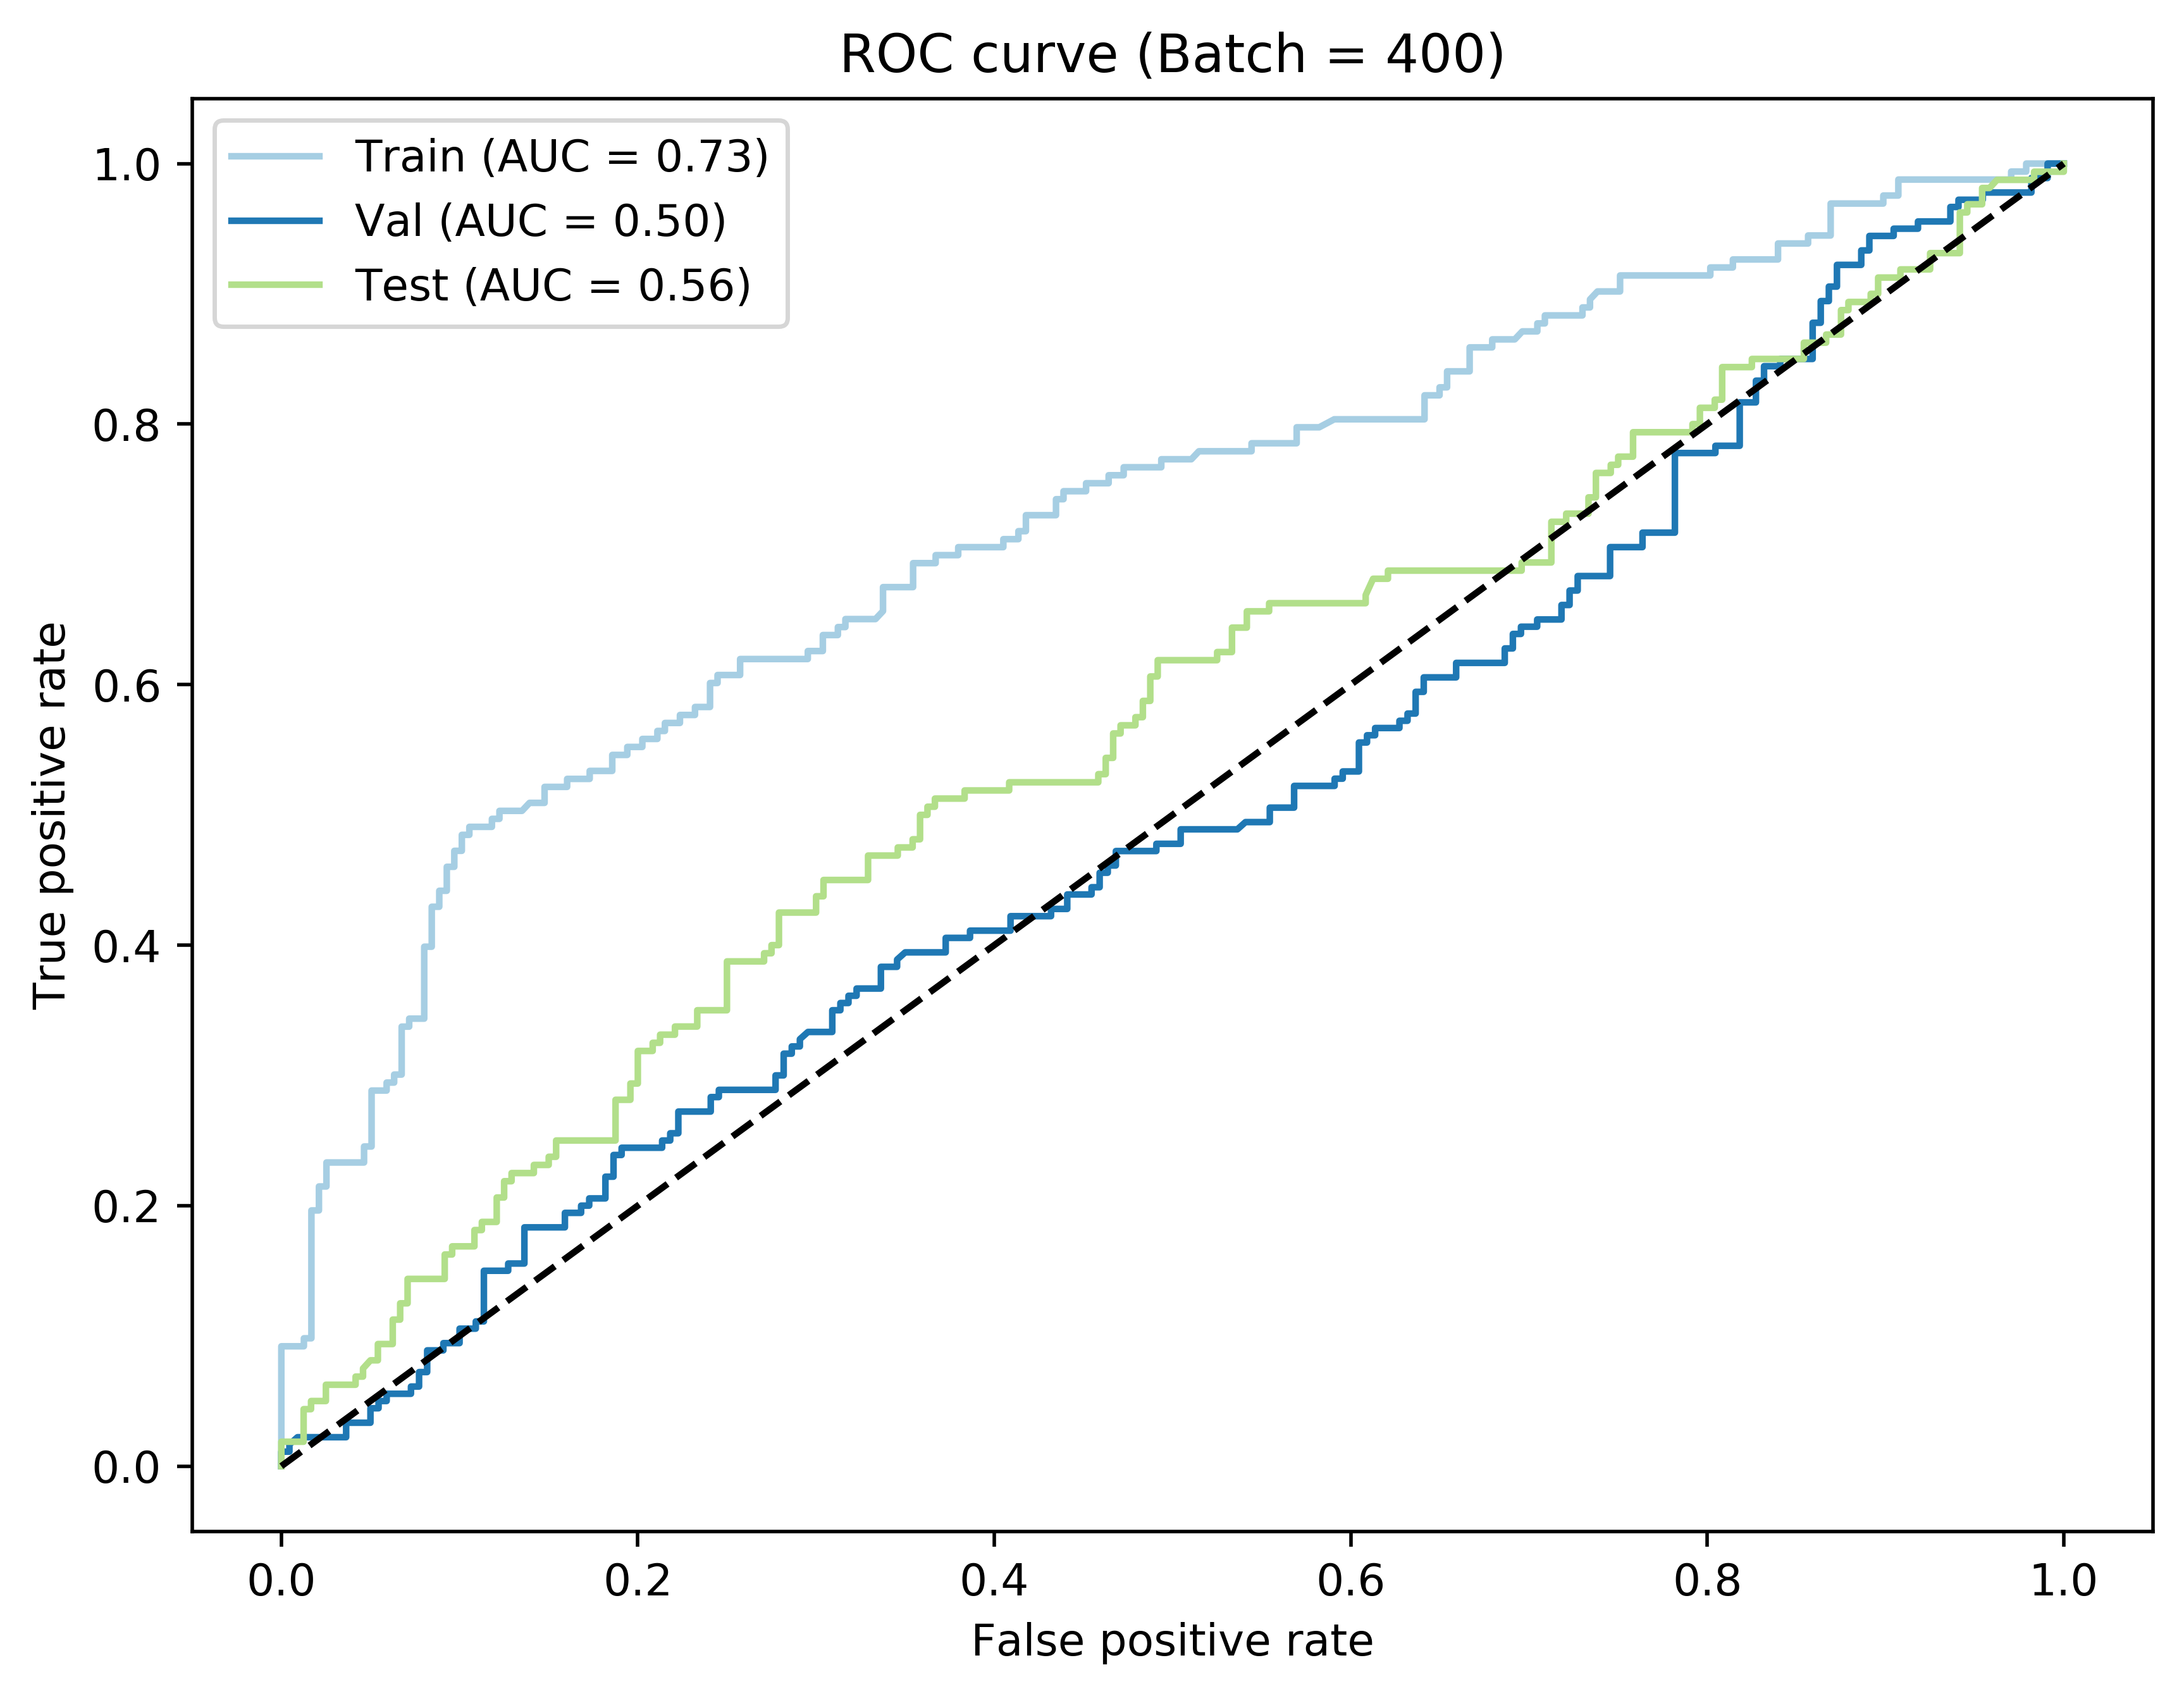

In [62]:
from sklearn import metrics

def calculate_roc(data):
    minibatch = build_batch(data, 400)
    X_encoded, X_mask, y_target = minibatch
    scores = code_to_score_model(X_encoded, X_mask).detach().cpu().numpy()
    # pos label
    scores = scores[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_target, scores, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    return fpr, tpr, auc
    
if is_classification:
    train_fpr, train_tpr, train_auc = calculate_roc(train_data)
    test_fpr, test_tpr, test_auc = calculate_roc(test_data)
    val_fpr, val_tpr, val_auc = calculate_roc(val_data)

    plt.figure(figsize=(8,6))
    plt.plot(train_fpr, train_tpr)
    plt.plot(val_fpr, val_tpr)
    plt.plot(test_fpr, test_tpr)
    plt.title('ROC curve (Batch = 400)')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.legend(['Train (AUC = {:.2f})'.format(train_auc), 'Val (AUC = {:.2f})'.format(val_auc), 'Test (AUC = {:.2f})'.format(test_auc)])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')